# Stalk the Stock

Importing libraries and modules

In [1]:
import numpy as np

import pandas as pd
from pandas_datareader import data as web

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode()

import warnings
warnings.simplefilter("ignore")

from datetime import date, timedelta
import time

import yfinance as yf

import cufflinks as cf
cf.go_offline()

from scipy.signal import argrelextrema
from scipy.stats import linregress

Stock input and fetching its data

In [2]:
stock_name = input("Enter the stock name\n")
stock_data = yf.download(tickers = stock_name + '.NS' ,period = '1mo', interval = '5m')
stock_data

Enter the stock name
TATAELXSI
[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close  \
Datetime                                                                        
2022-07-06 09:15:00+05:30  8035.899902  8065.000000  8025.450195  8053.000000   
2022-07-06 09:20:00+05:30  8053.000000  8088.500000  8041.549805  8070.000000   
2022-07-06 09:25:00+05:30  8070.000000  8085.000000  8057.200195  8073.000000   
2022-07-06 09:30:00+05:30  8070.000000  8079.000000  8038.200195  8047.200195   
2022-07-06 09:35:00+05:30  8047.899902  8060.000000  8045.149902  8050.750000   
...                                ...          ...          ...          ...   
2022-08-05 15:10:00+05:30  9299.049805  9307.950195  9293.099609  9298.000000   
2022-08-05 15:15:00+05:30  9298.000000  9340.000000  9294.049805  9318.299805   
2022-08-05 15:20:00+05:30  9318.700195  9335.000000  9263.299805  9309.000000   
2022-08-05 15:25:00+05:30  9306.349609  9309.000000  9266.000000  9280.000000   
2022-08-05 15:30:00+05:30  9308.599609  9308.599609  9308.599609  9308.599609   

                             Adj Close  Volume  
Datetime                                        
2022-07-06 09:15:00+05:30  8053.000000       0  
2022-07-06 09:20:00+05:30  8070.000000    7028  
2022-07-06 09:25:00+05:30  8073.000000    4151  
2022-07-06 09:30:00+05:30  8047.200195    4152  
2022-07-06 09:35:00+05:30  8050.750000    1972  
...                                ...     ...  
2022-08-05 15:10:00+05:30  9298.000000   10529  
2022-08-05 15:15:00+05:30  9318.299805   27000  
2022-08-05 15:20:00+05:30  9309.000000   27380  
2022-08-05 15:25:00+05:30  9280.000000   13104  
2022-08-05 15:30:00+05:30  9308.599609       0  

[1726 rows x 6 columns]

Plotting Candlestick for the stock

In [3]:
#adding stock data(olhc and volume) to plot
x_axis = stock_data.index

opens = stock_data['Open']
low = stock_data['Low']
high = stock_data['High']
close = stock_data['Adj Close']
volume = stock_data['Volume']

#plotting the candlesticks chart
stock_candle = go.Candlestick(x=x_axis, open=opens, low=low,
                           high=high, close=close, name=stock_name+ '_candle')

stock_volume = go.Bar(x=x_axis, y=volume, name=stock_name + '_volume' )

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(trace=stock_candle, secondary_y=True)
fig.add_trace(trace=stock_volume, secondary_y=False)

#adding different timeframes to view the chart
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=15,
                     label="15M",
                     step="minute",
                     stepmode="backward"),
                dict(count=45,
                     label="45M",
                     step="minute",
                     stepmode="backward"),
                dict(count=1,
                     label="1HR",
                     step="hour",
                     stepmode="todate"),
                dict(count=1,
                     label="1D",
                     step="day",
                     stepmode="todate"),
                dict(count=3,
                     label="3D",
                     step="day",
                     stepmode="todate"),
                dict(count=7,
                     label="1W",
                     step="day",
                     stepmode="backward"),
                dict(count=14,
                     label="2W",
                     step="day",
                     stepmode="backward"),
                dict(count=1,
                     label="1M",
                     step="month",
                     stepmode="backward"),
                dict(label="All", step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

#labelling the chart
fig.update_layout(xaxis_title='Date',
                  yaxis_title="Price",
                  title=stock_name,
                  width=1250, height=800)

#removing the time period when the market is closed
fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=["2022-01-26", "2022-03-01", "2022-03-18", 
                    "2022-04-14", "2022-04-15", "2022-05-03", 
                    "2022-08-09", "2022-08-15", "2022-08-31", 
                    "2022-10-05", "2022-10-24", "2022-10-26", 
                    "2022-11-08"]),                    
        dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)
fig.show()

INDICATORS

In [4]:
#fetching historical stock data
stock_data = yf.download(tickers = stock_name + '.NS' ,period = '10y', interval = '1d')
x_axis = stock_data.index

[*********************100%***********************]  1 of 1 completed


Simple Moving Average (SMA)

In [5]:
#SMA for price and volume

#taking input from user for SMA parameters
x = int(input("Shorter Period for SMA\n") or 50)
y = int(input("Longer Period for SMA\n") or 200)
z = int(input("Period for average Volume\n") or 10)

#fetching data to be plotted
MAx_data = stock_data['Close'].rolling(x).mean()
MAy_data = stock_data['Close'].rolling(y).mean()
price_data = stock_data['Close']
Volume_MA_data = stock_data['Volume'].rolling(z).mean()

#plotting SMA
MAx = go.Scatter(x=x_axis, y=MAx_data, line=dict(color='green', width=1), name="SMA"+str(x))
MAy = go.Scatter(x=x_axis, y=MAy_data, line=dict(color='red', width=1), name="SMA"+str(y))
price = go.Scatter(x=x_axis, y=price_data, line=dict(color='orange', width=1), name="price")
stock_volume = go.Bar(x=x_axis, y=stock_data['Volume'], marker_color='blue',name=stock_name + '_volume' )
MA_volume = go.Scatter(x=x_axis, y=Volume_MA_data, line=dict(color='black', width=1), name="Volume_SMA"+str(z))

#storing SMA data
stock_data["SMA"+str(x)] = MAx_data
stock_data["SMA"+str(y)] = MAy_data
stock_data["Volume_SMA"+str(z)] = Volume_MA_data

fig = make_subplots(specs=[[{"secondary_y": True}]])

#removing time period when the market is closed
fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.add_trace(trace=stock_volume, secondary_y = False)
fig.add_trace(trace=MAx, secondary_y = True)
fig.add_trace(trace=MAy, secondary_y = True)
fig.add_trace(trace=price, secondary_y = True)
fig.add_trace(trace = MA_volume, secondary_y=False)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Shorter Period for SMA

Longer Period for SMA

Period for average Volume



In [6]:
# SMA Using cufflinks library for comparison.

qf=cf.QuantFig(stock_data, title=stock_name,legend='top',name='cf_SMA')
qf.add_sma(periods=20, color='green')
qf.add_sma(periods=200, color='red')

qf.iplot()

Exponential Moving Average (EMA)

Shorter Period for EMA

Longer Period for EMA



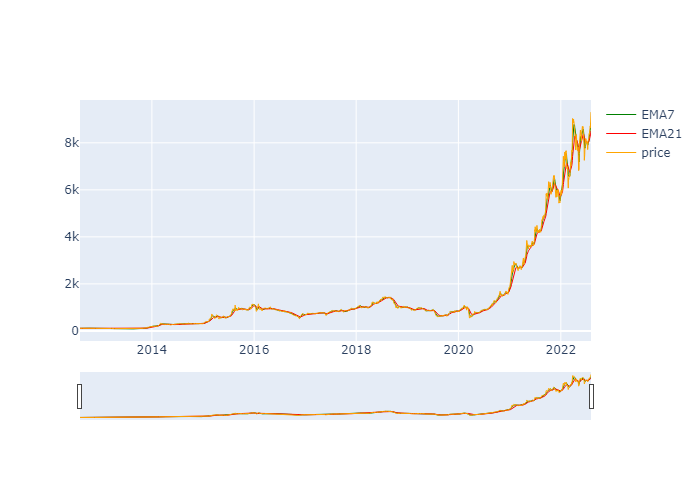

In [7]:
#EMA

#user input for EMA parameters
x = int(input("Shorter Period for EMA\n") or 7)
y = int(input("Longer Period for EMA\n") or 21)

#fetching data to plot EMA
EMAx_data = stock_data['Close'].ewm(span=x, adjust=False).mean()
EMAy_data = stock_data['Close'].ewm(span=y, adjust=False).mean()
price_data = stock_data['Close']

#storing EMA data
stock_data["EMA"+str(x)] = EMAx_data
stock_data["EMA"+str(y)] = EMAy_data

#plotting EMA
EMAx = go.Scatter(x=x_axis, y=EMAx_data, line=dict(color='green', width=1), name="EMA"+str(x))
EMAy = go.Scatter(x=x_axis, y=EMAy_data, line=dict(color='red', width=1), name="EMA"+str(y))
price = go.Scatter(x=x_axis, y=price_data, line=dict(color='orange', width=1), name="price")

fig = go.Figure()

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                        
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.add_trace(trace=EMAx)
fig.add_trace(trace=EMAy)
fig.add_trace(trace=price)
fig.update_xaxes(rangeslider_visible=True)
fig.show("png")

Relative Strength Index (RSI)

Enter the time period for RSI

Enter overbought region
Enter oversold region


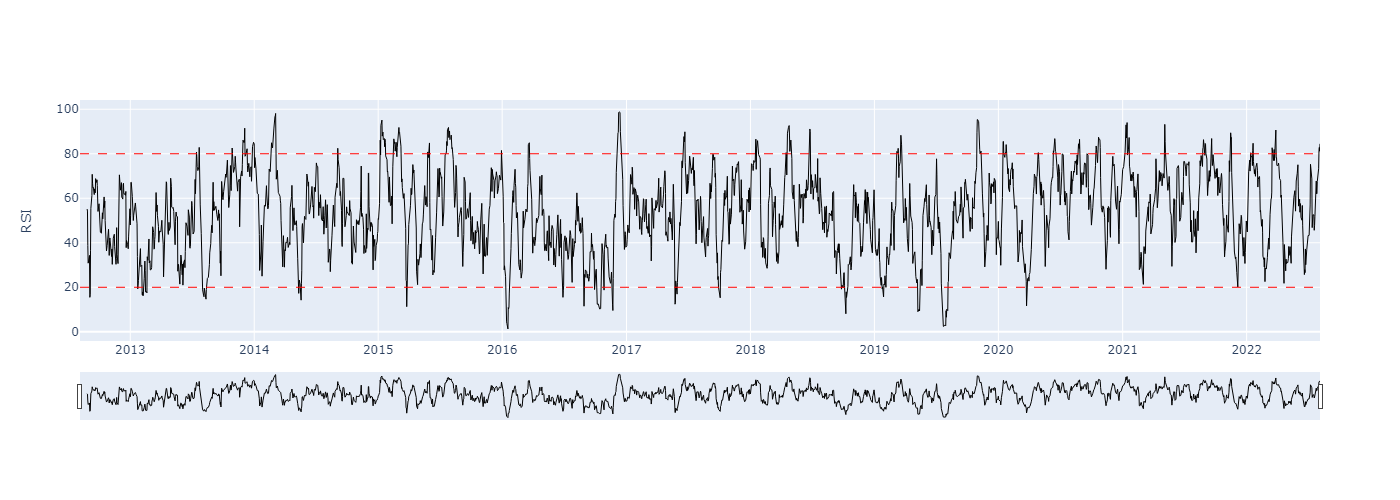

In [8]:
#RSI

#taking input from user for RSI parameter
period = int(input("Enter the time period for RSI\n") or 14)
a = int(input("Enter overbought region") or 80)
b = int(input("Enter oversold region") or 20)

#defining a function to calculate RSI 
def RSI(df,period):
    temp_df = pd.DataFrame()
    temp_df = df
    temp_df['Price_Change'] = temp_df['Close'] - temp_df['Close'].shift(1)
    temp_df['Daily_gain'] = np.where(temp_df['Price_Change']>=0,temp_df['Price_Change'],0)
    temp_df['Daily_loss'] = np.where(temp_df['Price_Change']<0,abs(temp_df['Price_Change']),0)
    temp_df['Avg_gain'] = temp_df['Daily_gain'].rolling(period).sum()
    temp_df['Avg_loss'] = temp_df['Daily_loss'].rolling(period).sum()
    temp_df['RS'] = temp_df['Avg_gain']/temp_df['Avg_loss']
    temp_df['RSI'] = (temp_df['RS']/(1+temp_df['RS']))*100
    df['RSI_'+str(period)] = temp_df['RSI']
    
RSI(stock_data,period)

#plotting RSI    
RSI_data = stock_data['RSI_'+str(period)]

RSI_curve = go.Scatter(x=x_axis, y=RSI_data, 
                      line=dict(color='black', width=1), name="RSI")

fig = go.Figure()
fig.add_trace(RSI_curve)
                                              
fig.update_xaxes(
    rangeslider_visible=True)
fig.update_yaxes(title="RSI")

fig.update_layout(height=500, width=1400)

fig.add_hline(y=b, line_width=1, line_dash="dash", line_color="red")
fig.add_hline(y=a, line_width=1, line_dash="dash", line_color="red")

fig.show("png")

MACD

Shorted Period

Longer Period

Signal Period



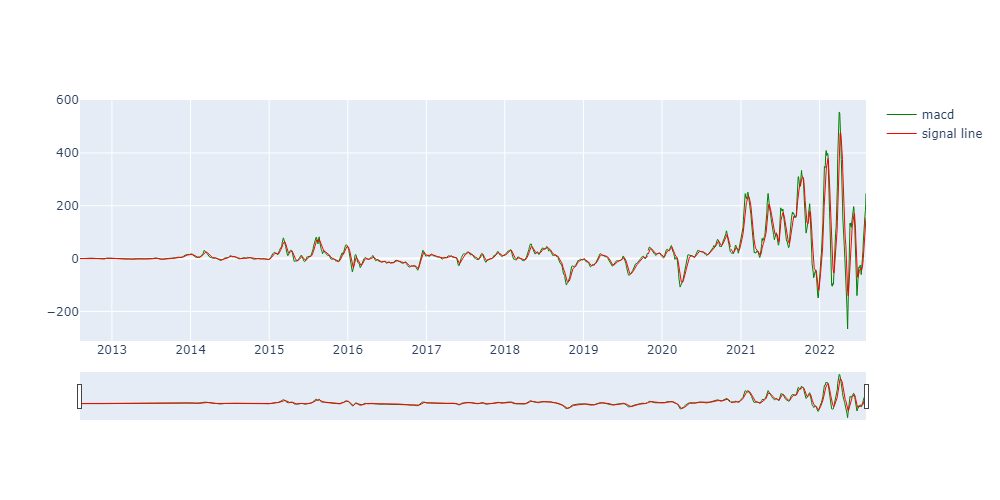

In [9]:
# MACD

#taking input from user for MACD parameters
sp = int(input("Shorted Period\n") or 12)
lp = int(input("Longer Period\n") or 26)
signal = int(input("Signal Period\n") or 9)

#fetching data for plotting MACD
ema_sp = stock_data['Close'].ewm(span = sp, adjust=False).mean()
ema_lp = stock_data['Close'].ewm(span = lp, adjust=False).mean()

macd_data = ema_sp - ema_lp

stock_data['MACD'+str(sp)+'_'+str(lp)] = macd_data

signal_line_data = macd_data.ewm(span = signal, adjust=False).mean()

#storing MACD data
stock_data['MACD_Signal_'+str(signal)] = signal_line_data

#plotting MACD
macd = go.Scatter(x = x_axis, y = macd_data, line=dict(color='green', width=1), name="macd")
signal_line = go.Scatter(x = x_axis, y = signal_line_data, line=dict(color='red', width=1), name="signal line")

fig = go.Figure()

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                          #for holidays
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=500, width=1000)
fig.add_trace(trace=macd)
fig.add_trace(trace=signal_line)
fig.update_xaxes(rangeslider_visible=True)
fig.show("png")

Bollinger Bands

In [10]:
#Bollinger bands

#user input for BB parameters
x = int(input("Enter the period for Bollinger Bands\n") or 20)
y = float(input("How many times the standard deviation do you want to enclose the band within?") or 2)

#fetching data for plotting BB
SMA = stock_data['Close'].rolling(x).mean()
SD = stock_data['Close'].rolling(x).std(ddof=1)

plus_SD = SMA + (SD*y) 
minus_SD = SMA - (SD*y) 

#plotting BB
candle = go.Candlestick(x=x_axis,
                       open=stock_data['Open'],
                       low=stock_data['Low'],
                       high=stock_data['High'],
                       close=stock_data['Close'])

Upper_band = go.Scatter(x=x_axis, y=plus_SD, line=dict(color='Black', width=1), name="Upper Band")
Lower_band = go.Scatter(x=x_axis, y=minus_SD, line=dict(color='Black', width=1), name="Lower Band")

fig =go.Figure()

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=500, width=1000)
fig.add_trace(candle)
fig.add_trace(trace=Upper_band)
fig.add_trace(trace=Lower_band)
fig.show()

Enter the period for Bollinger Bands

How many times the standard deviation do you want to enclose the band within?


ICHIMOKU

[*********************100%***********************]  1 of 1 completed


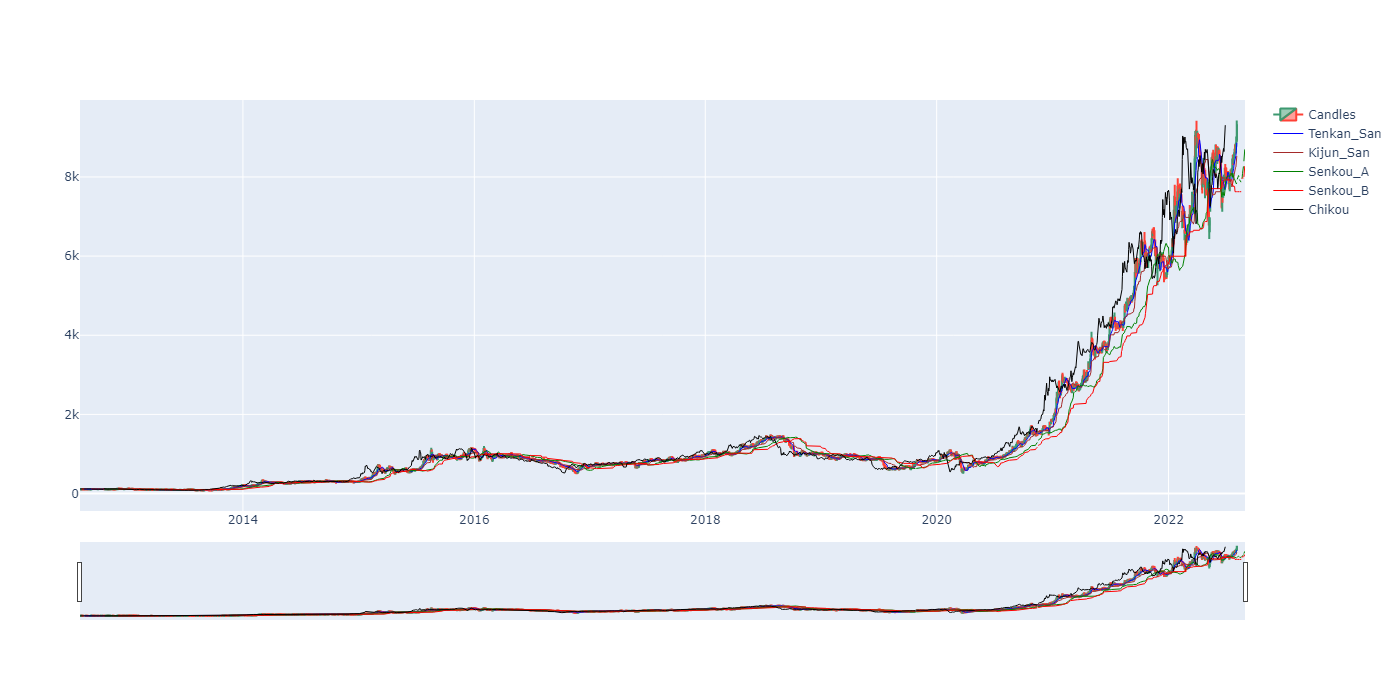

In [11]:
#fetching historical stock data to a new df
ichimoku_df = yf.download(tickers = stock_name + '.NS' ,period = '10y', interval = '1d')

#adding future days to our dataframe:
temp_table = [np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]

date_series = pd.Series(stock_data.index)
sdate = date_series.iloc[date_series.shape[0]-1]
edate = sdate+timedelta(days=40)
delta = edate - sdate     
temp_list = []

for i in range(1,delta.days + 1):
    day = sdate + timedelta(days=i)
    temp_list.append(day)
    
temp_series= pd.Series(temp_list)
date_ser = date_series.append(temp_series, ignore_index=True)

for i in range(26):
    ichimoku_df.at[ichimoku_df.shape[0]] = temp_table

ichimoku_df = ichimoku_df.reset_index()

#Defining ichimoku curve's data

#Tenkan San

ichimoku_df['high_nine'] = ichimoku_df['High'].rolling(9).max()
ichimoku_df['low_nine'] = ichimoku_df['Low'].rolling(9).min()
ichimoku_df['Tenkan_San'] = (ichimoku_df['high_nine'] + ichimoku_df['low_nine'])/2

#Kijun San

ichimoku_df['high_twenty_six'] = ichimoku_df['High'].rolling(26).max()
ichimoku_df['low_twenty_six'] = ichimoku_df['Low'].rolling(26).min()
ichimoku_df['Kijun_San'] = (ichimoku_df['high_twenty_six'] + ichimoku_df['low_twenty_six'])/2

#Leading lines

ichimoku_df['Senkou_A'] = ((ichimoku_df['Tenkan_San'] + ichimoku_df['Kijun_San'])/2).shift(26)

ichimoku_df['high_fifty_two'] = ichimoku_df['High'].rolling(52).max()
ichimoku_df['low_fifty_two'] = ichimoku_df['Low'].rolling(52).min()

ichimoku_df['Senkou_B'] = ((ichimoku_df['high_fifty_two'] + ichimoku_df['low_fifty_two'])/2).shift(26)

#Lagging line

ichimoku_df['Chikou'] = ichimoku_df['Close'].shift(-26)

#Candlesticks
candle = go.Candlestick(x=date_ser,
                       open=ichimoku_df['Open'],
                       low=ichimoku_df['Low'],
                       high=ichimoku_df['High'],
                       close=ichimoku_df['Close'],
                       name='Candles')

#plotting ichimoku
fig = go.Figure()
                              
Conversion_Line = go.Scatter(x=date_ser, y=ichimoku_df['Tenkan_San'], line=dict(color='blue',width=1), name='Tenkan_San')
Base_Line = go.Scatter(x=date_ser, y=ichimoku_df['Kijun_San'], line=dict(color='Brown',width=1), name='Kijun_San')
Leading_A = go.Scatter(x=date_ser, y=ichimoku_df['Senkou_A'], line=dict(color='green',width=1), name='Senkou_A')
Leading_B = go.Scatter(x=date_ser, y=ichimoku_df['Senkou_B'], line=dict(color='red',width=1), name='Senkou_B')
Lagging = go.Scatter(x=date_ser, y=ichimoku_df['Chikou'], line=dict(color='Black',width=1), name='Chikou')


fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=700, width=1400)
fig.add_trace(trace=candle)
fig.add_trace(trace=Conversion_Line)
fig.add_trace(trace=Base_Line)
fig.add_trace(trace=Leading_A)
fig.add_trace(trace=Leading_B)
fig.add_trace(trace=Lagging)

fig.show("png")

Stochastic Oscillator

Enter the period for Stochastic Oscillator

Enter overbought region

Enter oversold region



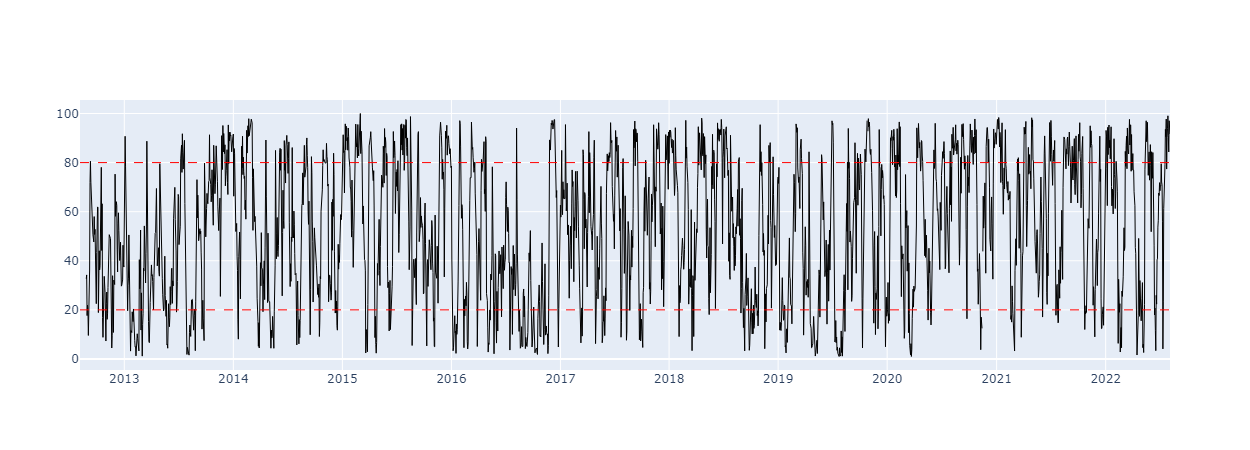

In [12]:
#Stochastic Oscillator

#getting input from user for indicator parameters
x = int(input('Enter the period for Stochastic Oscillator\n') or 14)
b = int(input('Enter overbought region\n') or 80)
a = int(input('Enter oversold region\n') or 20)

#getting necessary data to plot Stochastic Oscillator
high_val = stock_data['High'].rolling(window=x).max()
low_val = stock_data['Low'].rolling(window=x).min()
curr_val = stock_data['Close']
so_num = curr_val - low_val
so_den = high_val- low_val
so = (so_num/so_den)*100

#plotting the indicator
fig = go.Figure()

so_curve = go.Scatter(x=x_axis,y=so,
                     line=dict(color='black',width=1),
                     name='Stochastic_Curve')

fig.add_trace(trace=so_curve)
fig.add_hline(y=b, line_width=1, line_dash="dash", line_color="red")
fig.add_hline(y=a, line_width=1, line_dash="dash", line_color="red")

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=450, width=1250)

fig.show("png")


Average True Range

Enter period for ATR


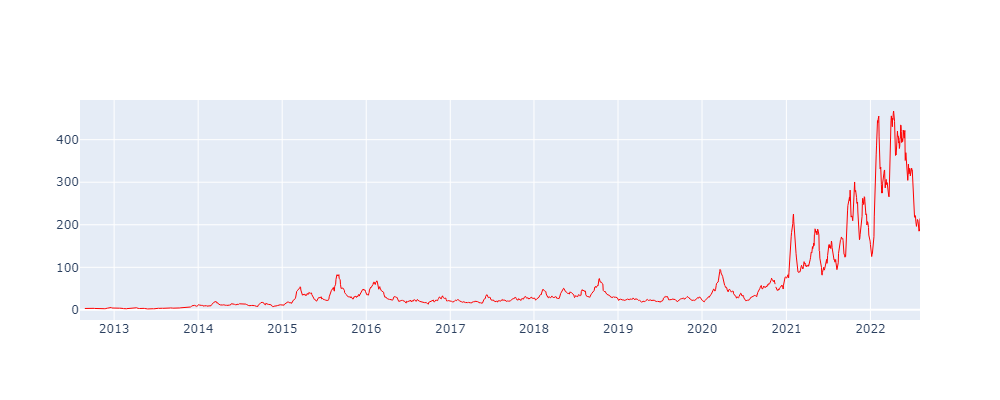

In [13]:
#ATR

#user input for ATR parameters
x = int(input("Enter period for ATR") or 14)

#getting necessary data for ATR plot
curr_high = stock_data['High']
curr_low = stock_data['Low']
prev_close = stock_data['Close'].shift(1)

a = abs(curr_high-prev_close)
b = abs(curr_low-prev_close)
c = curr_high - curr_low
        
temp_df = pd.concat([a, b, c], axis=1)
temp_df['True_Range'] = temp_df.max(axis=1)
temp_df['ATR'] = temp_df['True_Range'].rolling(x).mean()

#adding data to our df
stock_data['True_Range'] = temp_df['True_Range']
stock_data['ATR'] = temp_df['ATR']

#plotting
fig = go.Figure()

ATR_curve = go.Scatter(x=x_axis, y=temp_df['ATR'],
                      line=dict(color='red',width=1),
                      name='ATR')

fig.add_trace(trace=ATR_curve)

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=400, width=1000)
fig.show("png")

Average Directional Index

[*********************100%***********************]  1 of 1 completed


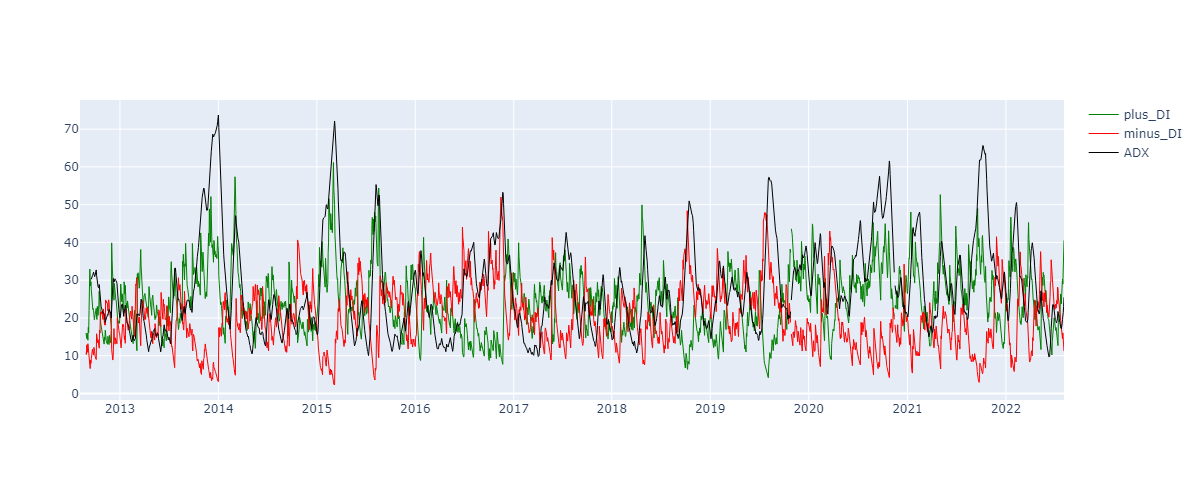

In [14]:
#ADX without library

#fetching historical data
temp_df = yf.download(tickers = stock_name + '.NS' ,period = '10y', interval = '1d')

#retrieving True Range from ATR.
temp_df['True_Range'] = stock_data['True_Range']
x_axis = temp_df.index

#getting data for plotting ADX
temp_df['plus_DM'] = np.where(((temp_df['High'] - temp_df['High'].shift(1)) >
                                 (temp_df['Low'].shift(1) - temp_df['Low'])) &
                                ((temp_df['High'] - temp_df['High'].shift(1)) > 0),
                                (temp_df['High'] - temp_df['High'].shift(1)),0)

temp_df['minus_DM'] = np.where(((temp_df['High'] - temp_df['High'].shift(1)) <
                                 (temp_df['Low'].shift(1) - temp_df['Low'])) &
                                ((temp_df['Low'].shift(1) - temp_df['Low']) > 0),
                                (temp_df['Low'].shift(1) - temp_df['Low']),0)

#function to implement wilder's smoothening for curves
def wilder_smoothening(name):
    smooth_it = 'smooth_'+name
    first_smooth = temp_df[name].head(14).sum()

    temp_df[smooth_it] = np.nan

    temp_df.at[temp_df.index[14],smooth_it] = first_smooth

    temp = first_smooth

    for i in range(15,temp_df.shape[0]):
        temp_df.at[temp_df.index[i],smooth_it] = temp - temp/14 + temp_df.loc[temp_df.index[i],name]
        temp = temp_df.loc[temp_df.index[i],smooth_it]

wilder_smoothening('True_Range')
wilder_smoothening('plus_DM')
wilder_smoothening('minus_DM')

#getting +DI and -DI and DX
temp_df['plus_DI'] = (temp_df['smooth_plus_DM']/temp_df['smooth_True_Range'])*100
temp_df['minus_DI'] = (temp_df['smooth_minus_DM']/temp_df['smooth_True_Range'])*100

temp_df['DX'] = ((abs(temp_df['plus_DI'] - temp_df['minus_DI']))/
                   (temp_df['plus_DI'] + temp_df['minus_DI'])) * 100

#getting ADX
temp_sum = 0
for i in range(15,28):
    temp_sum += temp_df.loc[temp_df.index[i],'DX']

first_ADX = temp_sum/14

temp_df['ADX'] = np.nan

temp_df.at[temp_df.index[28],'ADX'] = first_ADX

temp = first_ADX

for i in range(29,temp_df.shape[0]):
    temp_df.at[temp_df.index[i],'ADX'] = ((temp*13) + temp_df.loc[temp_df.index[i],'DX'])/14
    temp = temp_df.loc[temp_df.index[i],'ADX']
    
#adding data to our df
stock_data['plus_DI'] = temp_df['plus_DI']
stock_data['minus_DI'] = temp_df['minus_DI']
stock_data['ADX'] = temp_df['ADX']
 
#plotting ADX
fig = go.Figure()
                              

plus_DI = go.Scatter(x=x_axis, y=temp_df['plus_DI'], line=dict(color='green',width=1), name='plus_DI')
minus_DI = go.Scatter(x=x_axis, y=temp_df['minus_DI'], line=dict(color='red',width=1), name='minus_DI')
ADX = go.Scatter(x=x_axis, y=temp_df['ADX'], line=dict(color='Black',width=1), name='ADX')


fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=480, width=1200)
fig.add_trace(trace=plus_DI)
fig.add_trace(trace=minus_DI)
fig.add_trace(trace=ADX)

fig.show("png")


Commodity Channel Indicator

Enter the period



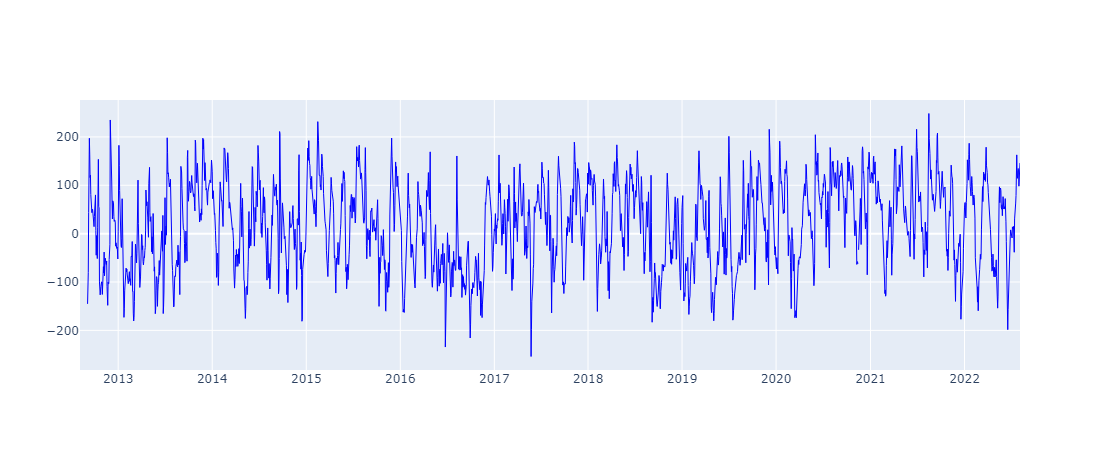

In [15]:
#CCI

#getting user input for CCI parameters
x = int(input("Enter the period\n") or 20)

#getting necessary data for plotting CCI
Typical_Price = (stock_data['High'] + 
                 stock_data['Low'] + 
                 stock_data['Close'])/3

TP_sma = Typical_Price.rolling(x).mean()
TP_std = Typical_Price.rolling(x).std()

CCI = (((Typical_Price) - (TP_sma))/(0.015*TP_std))

#plotting
fig = go.Figure()

CCI_curve = go.Scatter(x=x_axis, y=CCI,
                      line=dict(color='blue',width=1),
                      name='CCI')

fig.add_trace(trace=CCI_curve)

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=450, width=1100)
fig.show("png")

PLOTTING on Candlestick Charts

TRENDLINE

Enter the periods for a trend to be considered



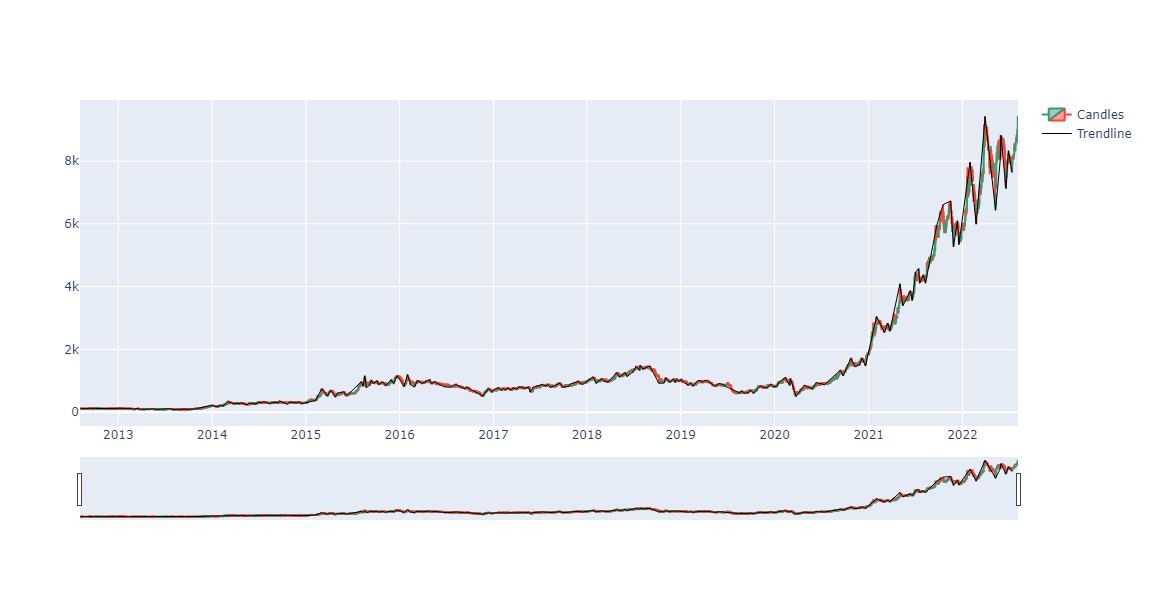

In [16]:
#Trendline based on local minima(lows price point) and local maxima(highs price point)

#user input for trend period
x = int(input("Enter the periods for a trend to be considered\n") or 7)

#using argrelextrema function to identify local minima and maxima to plot pattern
local_maxima = np.array(argrelextrema(stock_data['High'].values, np.greater, order=x))
local_minima = np.array(argrelextrema(stock_data['Low'].values, np.less, order=x))

#segregating x(date) and y(price corresponding to local maxima and minima) and index(0,1,2,3...)
peaks_x_data = []
peaks_y_data = []
peaks_z_data = []

for i in range(local_maxima.size):
    peaks_x_data.append(stock_data.index[local_maxima[0,i]])
    peaks_y_data.append(stock_data.loc[stock_data.index[local_maxima[0,i]],'High'])
    peaks_z_data.append(1)
    
valleys_x_data = []   
valleys_y_data = []
valleys_z_data = []

#merging local minima and local maxima data and sorting them
for i in range(local_minima.size):
    valleys_x_data.append(stock_data.index[local_minima[0,i]])
    valleys_y_data.append(stock_data.loc[stock_data.index[local_minima[0,i]],'Low'])
    valleys_z_data.append(-1)
    
df = pd.DataFrame()

df['x_data'] = np.hstack((peaks_x_data, valleys_x_data))
df['y_data'] = np.hstack((peaks_y_data, valleys_y_data))
df['Peak(1)/Valley(-1)'] = np.hstack((peaks_z_data, valleys_z_data))

df.sort_values('x_data',inplace=True)

#adding data to our df
df.reset_index()
stock_data['Peak(1)/Valley(-1)'] = 0

for i in range(df.shape[0]):
    stock_data.at[df.loc[i,'x_data'],'Peak(1)/Valley(-1)'] = df.loc[i,'Peak(1)/Valley(-1)']

#plotting
candle = go.Candlestick(x=x_axis,
                       open=stock_data['Open'],
                       low=stock_data['Low'],
                       high=stock_data['High'],
                       close=stock_data['Close'],
                       name='Candles')

trends = go.Scatter(x=df['x_data'], y=df['y_data'], line=dict(color='black',width=1), name='Trendline')

fig = go.Figure()

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=600, width=1150)
fig.add_trace(trace=candle)
fig.add_trace(trace=trends)

fig.show("png")

Enter the periods for a trend to be considered



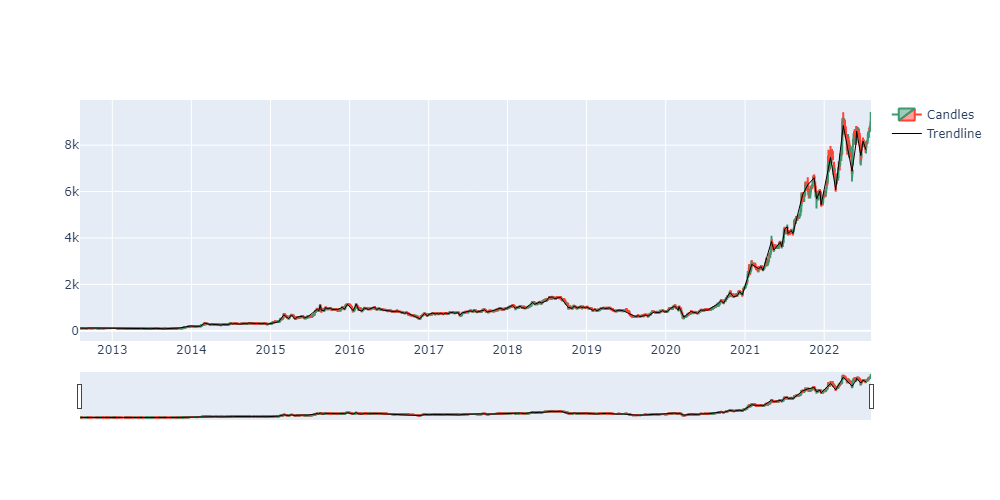

In [17]:
#Trendline based on Close price

#user input for trend period
x = int(input("Enter the periods for a trend to be considered\n") or 7)

#getting local minima and local maxima
local_maxima = np.array(argrelextrema(stock_data['High'].values, np.greater, order=x))
local_minima = np.array(argrelextrema(stock_data['Low'].values, np.less, order=x))

#merging and sorting local minima and local maxima data
trendline_data = np.hstack((local_maxima, local_minima))
sorted_trendline_data = np.sort(trendline_data)

x_data = []
y_data = []

for i in range(sorted_trendline_data.size):
    x_data.append(stock_data.index[sorted_trendline_data[0,i]])
    y_data.append(stock_data.loc[stock_data.index[sorted_trendline_data[0,i]],'Close'])
    
#plotting
candle = go.Candlestick(x=x_axis,
                       open=stock_data['Open'],
                       low=stock_data['Low'],
                       high=stock_data['High'],
                       close=stock_data['Close'],
                       name='Candles')

trends = go.Scatter(x=x_data, y=y_data, line=dict(color='black',width=1), name='Trendline')

fig = go.Figure()

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=500, width=1000)
fig.add_trace(trace=candle)
fig.add_trace(trace=trends)

fig.show("png")

Storing Trend Data and Trend Reversal data points

In [18]:
# 1  : uptrend
# -1 : downtrend
# 0  : reversal

#new column to store main trend
stock_data['Main_Trend'] = 0

#first peak/valley
first_extreme_value = stock_data.loc[x_data[0],'Close']
posi = stock_data.index[local_minima[0,0]]
if(first_extreme_value == stock_data.loc[posi,'Close']):
    first_extreme = -1
else:
    first_extreme = 1
    
#trend for remaining period
index = 0
interval = sorted_trendline_data[0,index]
up_value = 1
down_value = -1
if(first_extreme == -1):
    value = down_value
elif(first_extreme == 1):
    value = up_value
for i in range(stock_data.shape[0]):
    if(i != interval):
        stock_data.at[stock_data.index[i],'Main_Trend'] = value
    elif(i == interval):
        stock_data.at[stock_data.index[i],'Main_Trend'] = 0
        index += 1
        if(index < sorted_trendline_data.size):
            interval = sorted_trendline_data[0,index]
        elif(index == sorted_trendline_data.size):
            interval = stock_data.shape[0]-1
        if(value == up_value):
            value = down_value
        else:
            value = up_value
            
stock_data['Main_Trend'].tail(5)

Date
2022-08-01    1
2022-08-02    1
2022-08-03    1
2022-08-04    1
2022-08-05    1
Name: Main_Trend, dtype: int64

Parabolic Support and Resistance

[*********************100%***********************]  1 of 1 completed


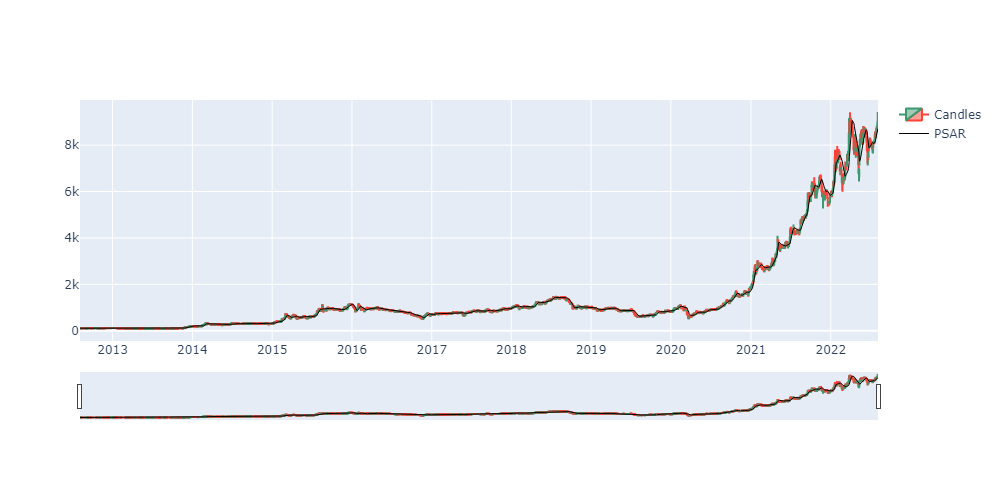

In [19]:
#plotting Parabolic SAR

#fetching historical stock data
temp_df = yf.download(tickers = stock_name + '.NS' ,period = '10y', interval = '1d')
x_axis = temp_df.index

#adding more attributes to store PSAR parameters
temp_df[['PSAR','EP','EP_PSAR','Acc_EP_PSAR','Acc','Trend']] = np.nan

#setting up initial values to further find PSAR
first_PSAR = temp_df.loc[temp_df.index[0],'Low']
first_EP = temp_df.loc[temp_df.index[0],'High']

if(temp_df.loc[temp_df.index[0],'Close'] <= df['y_data'][0]):
    first_trend = 1
else:
    first_trend = 0
    
#setting the initial values on our dataframe
temp_df.at[temp_df.index[0],'PSAR'] = first_PSAR
temp_df.at[temp_df.index[0],'EP'] = first_EP
temp_df.at[temp_df.index[0],'Trend'] = first_trend
temp_df.at[temp_df.index[0],'Acc'] = 0.02
temp_df.at[temp_df.index[0],'EP_PSAR'] = first_EP - first_PSAR
temp_df.at[temp_df.index[0],'Acc_EP_PSAR'] = (first_EP - first_PSAR)*0.02
    
#defining a PSAR function to calculate PSAR
def psar(i):
    #PSAR
    temp_df.at[temp_df.index[i],'PSAR'] = temp_df.loc[temp_df.index[i-1],'PSAR'] + temp_df.loc[temp_df.index[i-1],'Acc_EP_PSAR']
    
    #Trend
    
    if(temp_df.loc[temp_df.index[i],'PSAR'] < temp_df.loc[temp_df.index[i],'High']):
        temp_df.at[temp_df.index[i],'Trend'] = 1
    elif(temp_df.loc[temp_df.index[i],'PSAR'] > temp_df.loc[temp_df.index[i],'Low']):
        temp_df.at[temp_df.index[i],'Trend'] = -1
    
    #EP
    
    if(temp_df.loc[temp_df.index[i],'Trend'] == 1):
        if(temp_df.loc[temp_df.index[i],'High']>temp_df.loc[temp_df.index[i-1],'EP']):
            temp_df.at[temp_df.index[i],'EP'] = temp_df.loc[temp_df.index[i],'High']
        else:
            temp_df.at[temp_df.index[i],'EP'] = temp_df.loc[temp_df.index[i-1],'EP']
    elif(temp_df.loc[temp_df.index[i],'Trend'] == -1):
        if(temp_df.loc[temp_df.index[i],'Low']<temp_df.loc[temp_df.index[i-1],'EP']):
            temp_df.at[temp_df.index[i],'EP'] = temp_df.loc[temp_df.index[i],'Low']
        else:
            temp_df.at[temp_df.index[i],'EP'] = temp_df.loc[temp_df.index[i-1],'EP']
    
    #EP_PSAR
    
    temp_df.at[temp_df.index[i],'EP_PSAR'] = temp_df.at[temp_df.index[i],'EP'] - temp_df.at[temp_df.index[i],'PSAR']
    
    #Acc
  
    if(temp_df.loc[temp_df.index[i],'Trend'] == temp_df.loc[temp_df.index[i-1],'Trend']):
        if(temp_df.loc[temp_df.index[i],'Trend'] == 1):
            if(temp_df.loc[temp_df.index[i],'EP'] > temp_df.loc[temp_df.index[i-1],'EP']):
                if(temp_df.loc[temp_df.index[i-1],'Acc']>0.2):
                    temp_df.at[temp_df.index[i],'Acc'] = 0.2
                else:
                    temp_df.at[temp_df.index[i],'Acc'] = temp_df.loc[temp_df.index[i-1],'Acc'] + 0.02
            else:
                temp_df.at[temp_df.index[i],'Acc'] = temp_df.loc[temp_df.index[i-1],'Acc']

        if(temp_df.loc[temp_df.index[i],'Trend'] == -1):
            if(temp_df.loc[temp_df.index[i],'EP'] < temp_df.loc[temp_df.index[i-1],'EP']):
                if(temp_df.loc[temp_df.index[i-1],'Acc'] < 0.2):
                    temp_df.at[temp_df.index[i],'Acc'] = temp_df.loc[temp_df.index[i-1],'Acc'] + 0.02
                else:
                    temp_df.at[temp_df.index[i],'Acc'] = 0.2
            else:
                temp_df.at[temp_df.index[i],'Acc'] = temp_df.loc[temp_df.index[i-1],'Acc']
    else:
        temp_df.at[temp_df.index[i],'Acc'] = 0.02
    
    #Acc_EP_PSAR
    
    temp_df.at[temp_df.index[i],'Acc_EP_PSAR'] = temp_df.at[temp_df.index[i],'EP_PSAR'] * temp_df.at[temp_df.index[i],'Acc']
     
for x in range(1, temp_df.shape[0]):
    psar(x)

#adding data to our df
stock_data['PSAR'] = temp_df['PSAR']
stock_data['Trend'] = temp_df['Trend']
    
#plotting PSAR
candle = go.Candlestick(x=x_axis,
                       open=temp_df['Open'],
                       low=temp_df['Low'],
                       high=temp_df['High'],
                       close=temp_df['Close'],
                       name='Candles')

PSAR_data = go.Scatter(x=x_axis, y=temp_df['PSAR'], line=dict(color='black',width=1), name='PSAR')

fig = go.Figure()

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=500,width=1000)
fig.add_trace(trace=candle)
fig.add_trace(trace=PSAR_data)

fig.show("png")

HORIZONTAL LINES

Enter price

Draw another line?(Y/N)
N


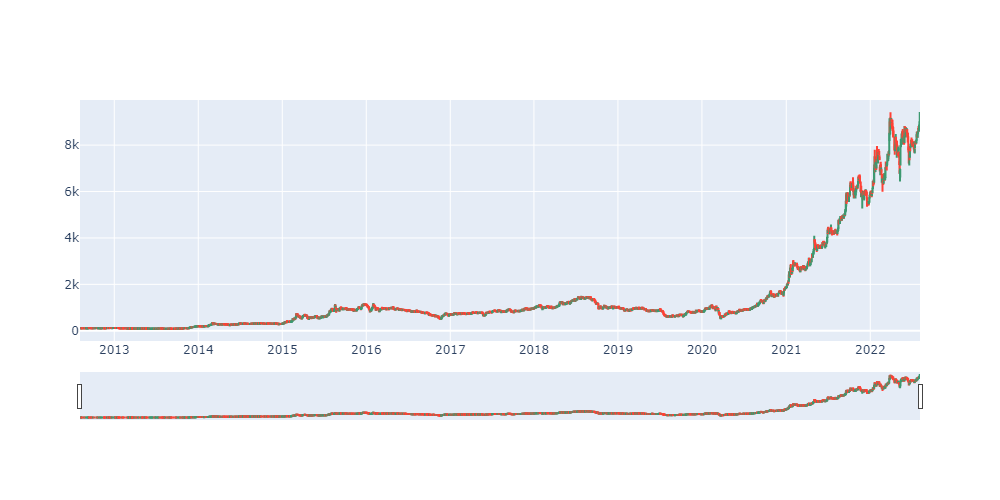

In [20]:
#Horizontal line based on price

#plotting candle and horizontal line
candle = go.Candlestick(x=x_axis,
                       open=stock_data['Open'],
                       low=stock_data['Low'],
                       high=stock_data['High'],
                       close=stock_data['Close'],
                       name='Candles')

fig = go.Figure()
fig.add_trace(trace=candle)
fig.update_layout(height=500,width=1000)
fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

#loop for multiple lines
answer='Y'

while(answer=='Y'):
    x = input("Enter price\n" or 500)
    
    fig.add_hline(y=x, line_width=1, line_dash="solid", line_color="black")

    answer = input("Draw another line?(Y/N)\n")

fig.show("png")

#CandleStick Patterns

In [21]:
#storing indicator data in stock_data_indicator_df
stock_data_indicator_df = stock_data
trend = stock_data['Trend']

#fetching historical stock data
stock_data = yf.download(tickers = stock_name + '.NS' ,period = '10y', interval = '1d')
stock_data['Trend'] = trend

[*********************100%***********************]  1 of 1 completed


MARUBUZO(Bullish and Bearish)

In [22]:
#Marubuzo

#user input for Marubuzo parameter
shadow_length = (float(input("Enter shadow range(%) for marubuzo\n") or 0.25))/100
max_candle_length = (float(input("Enter maximum candle length(%) for marubuzo\n") or 10))/100
min_candle_length = (float(input("Enter minimum candle length(%) for marubuzo\n") or 1))/100

#adding new attributes to store pattern information
stock_data['Bull_Maru'] = 0
stock_data['Bear_Maru'] = 0

#Defining algorithm to detect marubuzo
def marubuzo(i,o,l,h,c):    
    if(c>o):
        #Bull Maru
        if(((h-c)/c < shadow_length) & ((o-l)/o < shadow_length) & (min_candle_length < (c-o)/o < max_candle_length)):
            stock_data.at[stock_data.index[i],'Bull_Maru'] = 1
    elif(o>c):
        #Bear Maru
        if(((c-l)/c < shadow_length) & ((h-o)/o < shadow_length) & (min_candle_length < (o-c)/c < max_candle_length)):
            stock_data.at[stock_data.index[i],'Bear_Maru'] = 1

for i in range(stock_data.shape[0]):
    marubuzo(i,
            stock_data.loc[stock_data.index[i],'Open'],
            stock_data.loc[stock_data.index[i],'Low'],
            stock_data.loc[stock_data.index[i],'High'],
            stock_data.loc[stock_data.index[i],'Close'])
    
#displaying dataframe
stock_data.tail(5)

Enter shadow range(%) for marubuzo

Enter maximum candle length(%) for marubuzo

Enter minimum candle length(%) for marubuzo



Open         High          Low        Close    Adj Close  \
Date                                                                     
2022-08-01  8724.0  8828.650391  8653.799805  8720.599609  8720.599609   
2022-08-02  8702.0  8704.000000  8590.099609  8641.750000  8641.750000   
2022-08-03  8625.0  8870.000000  8600.000000  8840.299805  8840.299805   
2022-08-04  8895.0  9024.950195  8760.000000  8956.700195  8956.700195   
2022-08-05  8953.0  9425.000000  8888.000000  9308.599609  9308.599609   

             Volume  Trend  Bull_Maru  Bear_Maru  
Date                                              
2022-08-01   245069    1.0          0          0  
2022-08-02   167283    1.0          0          0  
2022-08-03   408450    1.0          0          0  
2022-08-04   422086    1.0          0          0  
2022-08-05  1150442    1.0          0          0

Spinning Top

In [23]:
#Spinning Top

#user input for Spinning Top parameters
shadow_length = (float(input("Enter minimum shadow range(%) for spinning top\n") or 2))/100
max_candle_length = (float(input("Enter maximum candle length(%) for spinning top\n") or 1))/100

#adding new attribute to our dataframe to store pattern information
stock_data['Spinning_Top'] = 0

#Defining Spinning Top function to detect it's pattern
def spinning_top(i,o,l,h,c):
    if(c>o):
        if(((c-o)/c <= max_candle_length) & ((h-c)/c >= shadow_length) & ((o-l)/o >= shadow_length)):
            stock_data.at[stock_data.index[i],'Spinning_Top'] = 1
    elif(o>c):
        if(((o-c)/o <= max_candle_length) & ((h-o)/o >= shadow_length) & ((c-l)/c >= shadow_length)):
            stock_data.at[stock_data.index[i],'Spinning_Top'] = 1

for i in range(stock_data.shape[0]):
    spinning_top(i,
            stock_data.loc[stock_data.index[i],'Open'],
            stock_data.loc[stock_data.index[i],'Low'],
            stock_data.loc[stock_data.index[i],'High'],
            stock_data.loc[stock_data.index[i],'Close'])
    
#displaying dataframe
filt = (stock_data['Spinning_Top'] == 1)
stock_data[filt]['Spinning_Top'].tail(5)

Enter minimum shadow range(%) for spinning top

Enter maximum candle length(%) for spinning top



Date
2017-10-25    1
2017-11-07    1
2020-02-03    1
2020-03-27    1
2021-02-19    1
Name: Spinning_Top, dtype: int64

PAPER UMBREALLA (Hammer and Shooting Star)

In [24]:
#paper umbrella (Hammer and Shooting Star)

#user input for paper umbrella parameter
max_candle_length = (float(input("Enter maximum candle length(%) for spinning top\n") or 2))/100
shooting_star_upper_shadow = float(input("Enter how many times the candle length ought the upper shadow of Shooting Star should be?\n") or 2)
shooting_star_lower_shadow = (float(input("Enter lower shadow range(%) for shooting star\n") or 0.5))/100
hammer_upper_shadow = (float(input("Enter upper shadow range(%) for hammer\n") or 0.5))/100
hammer_lower_shadow = float(input("Enter how many times the candle length ought the lower shadow of Hammer should be?\n") or 2)

#adding new attributes to our dataframe to store pattern information
stock_data['Shooting_Star'] = 0
stock_data['Hammer'] = 0

#functions to detect umbrella pattern

def paper_umbrella(i,o,l,h,c):
    if(stock_data.loc[stock_data.index[i],'Trend'] == 1):
        shooting_star(i,o,l,h,c)
    elif(stock_data.loc[stock_data.index[i],'Trend'] == 0):
        hammer(i,o,l,h,c)
        
def shooting_star(i,o,l,h,c):
    if((c>o) & (0.004 < (c-o)/o < max_candle_length) & ((h-c)>=(shooting_star_upper_shadow)*(c-o)) & ((o-l)/l < shooting_star_lower_shadow)):
        stock_data.at[stock_data.index[i],'Shooting_Star'] = 1
        
def hammer(i,o,l,h,c):
    if((0.004 < (o-c)/o < max_candle_length) & ((c-l)>=(hammer_lower_shadow)*(o-c)) & ((h-o)/o < hammer_upper_shadow)):
        stock_data.at[stock_data.index[i],'Hammer'] = 1
    

for i in range(stock_data.shape[0]):
    paper_umbrella(i,
            stock_data.loc[stock_data.index[i],'Open'],
            stock_data.loc[stock_data.index[i],'Low'],
            stock_data.loc[stock_data.index[i],'High'],
            stock_data.loc[stock_data.index[i],'Close'])
    
#displaying dataframe
filt = ((stock_data['Hammer'] == 1) |
        (stock_data['Shooting_Star'] == 1))
stock_data[filt][['Hammer','Shooting_Star']].tail(5)

Enter maximum candle length(%) for spinning top

Enter how many times the candle length ought the upper shadow of Shooting Star should be?

Enter lower shadow range(%) for shooting star

Enter upper shadow range(%) for hammer

Enter how many times the candle length ought the lower shadow of Hammer should be?



Hammer  Shooting_Star
Date                             
2021-03-05       0              1
2021-04-16       0              1
2021-08-09       0              1
2021-08-25       0              1
2022-01-17       0              1

ENGULFING (Bullish and Bearish)

In [25]:
#Engulfing Pattern (Reversal)

#adding new attributes to our df to store pattern information
stock_data['Bull_Engulf'] = 0
stock_data['Bear_Engulf'] = 0

#defining functions to detect engulfing pattern
def engulfing_pattern(i,o,c,o_1,c_1):
    if((stock_data.loc[stock_data.index[i],'Trend'] == 1) &
      (stock_data.loc[stock_data.index[i-1],'Trend'] == 1)):
        bear_engulf(i,o,c,o_1,c_1)
    elif((stock_data.loc[stock_data.index[i],'Trend'] == 0) & 
        (stock_data.loc[stock_data.index[i-1],'Trend'] == 0)):
        bull_engulf(i,o,c,o_1,c_1)
        
def bear_engulf(i,o,c,o_1,c_1):
    if((o>c) & (c_1>o_1)):
        if((o>c_1) & (c<o_1)):
            stock_data.at[stock_data.index[i],'Bear_Engulf'] = 1
            
def bull_engulf(i,o,c,o_1,c_1):
    if((c>o) & (c_1<o_1)):
        if((c>o_1) & (o<c_1)):
            stock_data.at[stock_data.index[i],'Bull_Engulf'] = 1
    
for i in range(1,stock_data.shape[0]):
    engulfing_pattern(i,
            stock_data.loc[stock_data.index[i],'Open'],
            stock_data.loc[stock_data.index[i],'Close'],
            stock_data.loc[stock_data.index[i-1],'Open'],
            stock_data.loc[stock_data.index[i-1],'Close'])

#displaying dataframe wherein we got an engulfing pattern
filt = ((stock_data['Bull_Engulf'] == 1) |
       (stock_data['Bear_Engulf'] == 1))
stock_data[filt][['Bull_Engulf','Bear_Engulf']].tail(5)

Bull_Engulf  Bear_Engulf
Date                                
2022-01-07            0            1
2022-02-10            0            1
2022-04-05            0            1
2022-04-07            0            1
2022-07-26            0            1

HARAMI (Bullish and Bearish)

In [26]:
#Harami Reversal

#user input for pattern parameters
harami_length = (float(input("Enter how much should the candle be contained(%)\n") or 30))/100

#adding new attributes to our dataframe to store pattern information
stock_data['Bull_Harami'] = 0
stock_data['Bear_Harami'] = 0

#defining function to detect Harami pattern
def harami(i,o,c,o_1,c_1):
    if((stock_data.loc[stock_data.index[i],'Trend'] == 1) &
      (stock_data.loc[stock_data.index[i-1],'Trend'] == 1)):
        bear_harami(i,o,c,o_1,c_1)
    elif((stock_data.loc[stock_data.index[i],'Trend'] == 0) & 
        (stock_data.loc[stock_data.index[i-1],'Trend'] == 0)):
        bull_harami(i,o,c,o_1,c_1)
        
def bear_harami(i,o,c,o_1,c_1):
    if((o>c) & (c_1>o_1)):
        if((o<c_1) & (c>o_1)):
            if((o-c)>(harami_length*(c_1-o_1))):
                stock_data.at[stock_data.index[i],'Bear_Harami'] = 1
            
def bull_harami(i,o,c,o_1,c_1):
    if((c>o) & (c_1<o_1)):
        if((o>c_1) & (c<o_1)):
            if((c-o)>(harami_length*(o_1-c_1))):
                stock_data.at[stock_data.index[i],'Bull_Harami'] = 1
    
for i in range(1,stock_data.shape[0]):
    harami(i,
            stock_data.loc[stock_data.index[i],'Open'],
            stock_data.loc[stock_data.index[i],'Close'],
            stock_data.loc[stock_data.index[i-1],'Open'],
            stock_data.loc[stock_data.index[i-1],'Close'])

#displaying dataframe wherein we encountered Harami Pattern
filt = ((stock_data['Bull_Harami'] == 1)|
       (stock_data['Bear_Harami'] == 1))

stock_data[filt][['Bull_Harami','Bear_Harami']].tail(5)

Enter how much should the candle be contained(%)



Bull_Harami  Bear_Harami
Date                                
2020-04-16            0            1
2020-10-19            0            1
2020-11-19            0            1
2022-03-24            0            1
2022-03-29            0            1

GAPS(Up and Down)

In [27]:
#Gap up and Gap down  

#user input for pattern parameter
gap_range = (float(input("Enter the gap range(%) wrt previous close price\n") or 1))/100

#adding new attribute to our dataframe to store pattern information
stock_data['Gap_Up'] = 0
stock_data['Gap_Down'] = 0

#algorithm to detect gaps pattern
def gap(i,o,c,o_1,c_1):
    if((o>(c_1*gap_range+(c_1)))):
        if((c>o)):
            stock_data.at[stock_data.index[i],'Gap_Up'] = 1
        
    elif((o<(c_1-(c_1*gap_range)))):
        if((o>c)):
            stock_data.at[stock_data.index[i],'Gap_Down'] = 1
    

for i in range(stock_data.shape[0]):
    gap(i,
            stock_data.loc[stock_data.index[i],'Open'],
            stock_data.loc[stock_data.index[i],'Close'],
            stock_data.loc[stock_data.index[i-1],'Open'],
            stock_data.loc[stock_data.index[i-1],'Close'])
    
#displaying dataframe wherein we encountered gap pattern
filt = ((stock_data['Gap_Up'] == 1)|
       (stock_data['Gap_Down'] == 1))
stock_data[filt][['Gap_Up','Gap_Down']].tail(5)

Enter the gap range(%) wrt previous close price



Gap_Up  Gap_Down
Date                        
2022-05-31       1         0
2022-06-13       0         1
2022-06-17       0         1
2022-06-27       1         0
2022-07-15       1         0

STAR(Evening Star and Morning Star)

In [28]:
#Star Reversal pattern for smaller timeframe(1min,2min,5min...)

#adding new attributes to our df to store pattern information
stock_data['Evening_Star'] = 0
stock_data['Morning_Star'] = 0

#defining functions to detect star patterns
def star(i,o,c,o_1,c_1,o_2,c_2):
    if((stock_data.loc[stock_data.index[i],'Trend'] == 1) &
      (stock_data.loc[stock_data.index[i-1],'Trend'] == 1) &
      (stock_data.loc[stock_data.index[i-1],'Trend'] == 1)):
        evening_star(i,o,c,o_1,c_1,o_2,c_2)
        
def star(i,o,c,o_1,c_1,o_2,c_2):
    if((stock_data.loc[stock_data.index[i],'Trend'] == 0) &
      (stock_data.loc[stock_data.index[i-1],'Trend'] == 0) &
      (stock_data.loc[stock_data.index[i-1],'Trend'] == 0)):
        morning_star(i,o,c,o_1,c_1,o_2,c_2)

def evening_star(i,o,c,o_1,c_1,o_2,c_2):
    if((c_2>o_2) &
       (stock_data.loc[stock_data.index[i-1],'Gap_Up'] == 1) &
       (stock_data.loc[stock_data.index[i],'Gap_Down'] == 1) &
       (c<o_2)):
        stock_data.at[stock_data.index[i],'Evening_Star'] = 1
        
def morning_star(i,o,c,o_1,c_1,o_2,c_2):
    if((c_2<o_2) &
       (stock_data.loc[stock_data.index[i-1],'Gap_Down'] == 1) &
       (stock_data.loc[stock_data.index[i],'Gap_Up'] == 1) &
       (c>o_2)):
        stock_data.at[stock_data.index[i],'Morning_Star'] = 1
        
for i in range(stock_data.shape[0]):
    star(i,
            stock_data.loc[stock_data.index[i],'Open'],
            stock_data.loc[stock_data.index[i],'Close'],
            stock_data.loc[stock_data.index[i-1],'Open'],
            stock_data.loc[stock_data.index[i-1],'Close'],
            stock_data.loc[stock_data.index[i-2],'Open'],
            stock_data.loc[stock_data.index[i-2],'Close'])
    
#displaying df wherein we encountered star pattern
filt = ((stock_data['Evening_Star'] == 1)|
       (stock_data['Morning_Star'] ==1))
stock_data[filt][['Morning_Star','Evening_Star']].tail(5)

Empty DataFrame
Columns: [Morning_Star, Evening_Star]
Index: []

Saving our Candlestick patterns data in stock_data_patttern_df

In [29]:
stock_data_pattern_df = stock_data

Chart Patterns- Double Top, Double Bottom, Zig_Zag, Triple Top, Triple Bottom, Flag Up, Flag down

In [30]:
#RSI value around 41-59 indicate that during the period the market trended sideways with avg gain ~ avg loss
#RSI >= 60 implies an uptrend during the lookback period with avg gain > avg loss
#RSI <= 40 implies a downtrend during the lookback period with avg loss < avg gain

#Now a static RSI value over two period forms a Chart pattern with two symmetrical triangles.
#If the static RSI value over two period is around 41-59, look for double top or double bottom or zig_zag.
#If the static RSI value over two period is >=60, look for flag up pattern.
#If the static RSI value over two period is <=40, look for flag down pattern.

#we get RSI value for each period. if period=14, we get RSI for first 14 day and then for next 14 day one after other.
#Now if any two or more consecutive values same, we can proceed with the principles above.

#user input for chart patterns parameters
x = int(input("Enter Period\n") or 14)
y = float(input("Enter RSI allowable fluctuation in detecting pattern\n") or 2 )
a = float(input("Enter RSI value above which you want to consider uptrend\n") or 57)
b = float(input("Enter RSI value below which you want to consider downtrend\n") or 43)

#browsing through every RSI period(default=14) to store every period's(14 day's) RSI
date = []
period_RSI = []
for i in range(0,x-1):
    for j in range(i,stock_data_indicator_df.shape[0],x):
        date.append(stock_data_indicator_df.index[j])
        period_RSI.append(stock_data_indicator_df.loc[stock_data_indicator_df.index[j],'RSI_'+str(x)])

RSI_df = pd.DataFrame(period_RSI,index=date,columns=['RSI_'+str(x)])

#adding new attributes to our dataframe to store chart pattern information
stock_data_pattern_df['Double_Top/Double_Bottom'] = 0
stock_data_pattern_df['Triple_Top/Triple_Bottom'] = 0
stock_data_pattern_df['Flag_Up/Flag_Down'] = 0

#algorithm to detect chart patterns and store them
for i in range(RSI_df.shape[0]-2):
    curr_val = RSI_df.loc[RSI_df.index[i],'RSI_'+str(x)]
    next_val = RSI_df.loc[RSI_df.index[i+1],'RSI_'+str(x)]
    max_val = curr_val + y
    min_val = curr_val - y
    if((min_val <= next_val) & (next_val <= max_val)):
        if((next_val>=curr_val) &
           (next_val - (2*y) <= RSI_df.loc[RSI_df.index[i+2],'RSI_'+str(x)]) &
           (RSI_df.loc[RSI_df.index[i+2],'RSI_'+str(x)] <= next_val+y)):
            stock_data_pattern_df.at[RSI_df.index[i+1],'Triple_Top/Triple_Bottom'] = 1
        elif((next_val<curr_val) &
             (next_val-y <= RSI_df.loc[RSI_df.index[i+2],'RSI_'+str(x)]) &
             (RSI_df.loc[RSI_df.index[i+2],'RSI_'+str(x)]<= next_val+(2*y))):
            stock_data_pattern_df.at[RSI_df.index[i+1],'Triple_Top/Triple_Bottom'] = 1
        elif( (b <= curr_val) &
             (curr_val <= a)):
            stock_data_pattern_df.at[RSI_df.index[i+1],'Double_Top/Double_Bottom'] = 1
        elif(curr_val > a):
            stock_data_pattern_df.at[RSI_df.index[i+1],'Flag_Up/Flag_Down'] = 1
        elif(curr_val < b):
            stock_data_pattern_df.at[RSI_df.index[i+1],'Flag_Up/Flag_Down'] = -1
            
#displaying dataframe wherein we encountered a Double_Top/Double_Bottom pattern
filt = stock_data_pattern_df['Double_Top/Double_Bottom'] == 1
stock_data_pattern_df[filt].tail(5)

Enter Period

Enter RSI allowable fluctuation in detecting pattern

Enter RSI value above which you want to consider uptrend

Enter RSI value below which you want to consider downtrend



Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-12-14  1613.900024  1635.000000  1590.000000  1600.150024  1581.920898   
2022-01-05  6000.000000  6027.000000  5884.950195  5963.799805  5933.578125   
2022-03-09  6664.000000  7060.000000  6580.049805  6993.000000  6957.562988   
2022-06-08  8630.349609  8710.000000  8552.200195  8608.950195  8565.324219   
2022-07-05  8124.000000  8148.950195  7970.000000  8003.200195  8003.200195   

            Volume  Trend  Bull_Maru  Bear_Maru  Spinning_Top  ...  \
Date                                                           ...   
2020-12-14  256187   -1.0          0          0             0  ...   
2022-01-05  106351    1.0          0          0             0  ...   
2022-03-09  419890    1.0          0          0             0  ...   
2022-06-08  210199    1.0          0          0             0  ...   
2022-07-05  165819    1.0          0          0             0  ...   

            Bear_Engulf  Bull_Harami  Bear_Harami  Gap_Up  Gap_Down  \
Date                                                                  
2020-12-14            0            0            0       0         0   
2022-01-05            0            0            0       0         0   
2022-03-09            0            0            0       1         0   
2022-06-08            0            0            0       0         0   
2022-07-05            0            0            0       0         0   

            Evening_Star  Morning_Star  Double_Top/Double_Bottom  \
Date                                                               
2020-12-14             0             0                         1   
2022-01-05             0             0                         1   
2022-03-09             0             0                         1   
2022-06-08             0             0                         1   
2022-07-05             0             0                         1   

            Triple_Top/Triple_Bottom  Flag_Up/Flag_Down  
Date                                                     
2020-12-14                         0                  0  
2022-01-05                         0                  0  
2022-03-09                         0                  0  
2022-06-08                         0                  0  
2022-07-05                         0                  0  

[5 rows x 23 columns]

Dataframe of all the days where we encountered a pattern

In [31]:
filt = ((stock_data_pattern_df['Bull_Maru'] == 1) |
        (stock_data_pattern_df['Bear_Maru'] == 1) |
        (stock_data_pattern_df['Spinning_Top'] == 1) |
        (stock_data_pattern_df['Shooting_Star'] == 1) |
        (stock_data_pattern_df['Hammer'] == 1) |
        (stock_data_pattern_df['Bull_Engulf'] == 1) |
        (stock_data_pattern_df['Bear_Engulf'] == 1) |
        (stock_data_pattern_df['Bull_Harami'] == 1) |
        (stock_data_pattern_df['Bear_Harami'] == 1) |
        (stock_data_pattern_df['Gap_Up'] == 1) |
        (stock_data_pattern_df['Gap_Down'] == 1) |
        (stock_data_pattern_df['Evening_Star'] == 1) |
        (stock_data_pattern_df['Morning_Star'] == 1) |
        (stock_data_pattern_df['Double_Top/Double_Bottom'] == 1) |
        (stock_data_pattern_df['Triple_Top/Triple_Bottom'] == 1) |
        (stock_data_pattern_df['Flag_Up/Flag_Down'] == 1)
       )
pattern_signal_df = stock_data_pattern_df[filt]
pattern_signal_df.tail(5)

Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-07-05  8124.000000  8148.950195  7970.000000  8003.200195  8003.200195   
2022-07-15  7940.000000  8119.000000  7863.000000  8060.600098  8060.600098   
2022-07-26  8545.000000  8573.450195  8302.099609  8361.299805  8361.299805   
2022-07-27  8361.299805  8500.000000  8343.049805  8481.400391  8481.400391   
2022-07-29  8620.000000  8700.000000  8551.000000  8690.049805  8690.049805   

             Volume  Trend  Bull_Maru  Bear_Maru  Spinning_Top  ...  \
Date                                                            ...   
2022-07-05   165819    1.0          0          0             0  ...   
2022-07-15  1018820    1.0          0          0             0  ...   
2022-07-26   236934    1.0          0          0             0  ...   
2022-07-27   168885    1.0          1          0             0  ...   
2022-07-29   240863    1.0          0          0             0  ...   

            Bear_Engulf  Bull_Harami  Bear_Harami  Gap_Up  Gap_Down  \
Date                                                                  
2022-07-05            0            0            0       0         0   
2022-07-15            0            0            0       1         0   
2022-07-26            1            0            0       0         0   
2022-07-27            0            0            0       0         0   
2022-07-29            0            0            0       0         0   

            Evening_Star  Morning_Star  Double_Top/Double_Bottom  \
Date                                                               
2022-07-05             0             0                         1   
2022-07-15             0             0                         0   
2022-07-26             0             0                         0   
2022-07-27             0             0                         0   
2022-07-29             0             0                         0   

            Triple_Top/Triple_Bottom  Flag_Up/Flag_Down  
Date                                                     
2022-07-05                         0                  0  
2022-07-15                         0                  0  
2022-07-26                         0                  0  
2022-07-27                         0                  0  
2022-07-29                         0                  1  

[5 rows x 23 columns]

Stock statistical Analysis and Machine Learning model for Trend Prediction

Importing additional libraries and modules for statistics and machine learning

In [32]:
from scipy.stats import linregress

from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

from xgboost import XGBClassifier,plot_importance

Fetching stock historical data

In [33]:
#stock_data_indicator_df.dropna(inplace=True)
stock_data = yf.download(tickers = stock_name + '.NS' ,period = '10y', interval = '1d')

[*********************100%***********************]  1 of 1 completed


Functions to normalize price points between 0-100 and functions to calculate covariance and correlation

In [34]:
def normalize(temp_series,name):
    stock_data['Normalized_'+name] = np.nan
    min_value = stock_data_indicator_df[name].min()
    max_value = stock_data_indicator_df[name].max()
    
    for i in range(stock_data_indicator_df.shape[0]):
        stock_data.at[stock_data_indicator_df.index[i],'Normalized_'+name] = ((stock_data_indicator_df.loc[stock_data_indicator_df.index[i],name]-min_value)/(max_value-min_value))*100

def covariance(series_x,series_y):
    temp_df = pd.concat([series_x,series_y],axis=1)
    temp_df.dropna(inplace=True)
    x_mean = series_x.mean()
    y_mean = series_y.mean()
    x_diff = series_x-x_mean
    y_diff = series_y-y_mean
    numerator = (x_diff*y_diff).sum()
    covariance = numerator/temp_df.shape[0]
    return covariance
    
def correlation(series_x,series_y):
    temp_df = pd.concat([series_x,series_y],axis=1)
    temp_df.dropna(inplace=True)
    x_mean = series_x.mean()
    y_mean = series_y.mean()
    x_diff = series_x-x_mean
    y_diff = series_y-y_mean
    numerator = (x_diff*y_diff).sum()
    covariance = numerator/temp_df.shape[0]
    corr_coeff = covariance/(series_x.std()*series_y.std())
    return corr_coeff
    

Aim 1: To Check covariance and correlation between Indicators (RSI and ADX) and close price of the same day.

In [35]:
normalize(stock_data_indicator_df['Close'],'Close')
normalize(stock_data_indicator_df['Open'],'Open')
indicator = ['RSI','ADX']
for i in indicator:
    normalize(stock_data_indicator_df[i],i)
    print("The covariance between "+i+" and today's Close Price is:\t")
    print(covariance(stock_data['Normalized_RSI'],stock_data['Normalized_Close']))
    print("The correlation between "+i+" and today's Close Price is:\t")
    print(correlation(stock_data['Normalized_RSI'],stock_data['Normalized_Close']))

The covariance between RSI and today's Close Price is:	
44.77949930298188
The correlation between RSI and today's Close Price is:	
0.11138940830906845
The covariance between ADX and today's Close Price is:	
44.77949930298188
The correlation between ADX and today's Close Price is:	
0.11138940830906845


Inference: There seems to be no direct relation between the RSI or ADX and the Close price of the same day.

Aim 2: To check if there is any relation between indicators(RSI,ADX) and next day price point.

In [36]:
indicator = ['RSI','ADX']
for i in indicator:
    normalize(stock_data_indicator_df[i],i)
    print("The covariance between "+i+" and future Close Price is:\t")
    print(covariance(stock_data['Normalized_RSI'],stock_data['Normalized_Open'].shift(-1)))
    print("The correlation between "+i+" and future Close Price is:\t")
    print(correlation(stock_data['Normalized_RSI'],stock_data['Normalized_Open'].shift(-1)))

The covariance between RSI and future Close Price is:	
45.14485458741288
The correlation between RSI and future Close Price is:	
0.10948721873206513
The covariance between ADX and future Close Price is:	
45.14485458741288
The correlation between ADX and future Close Price is:	
0.10948721873206513


Inference: There seems to be no direct relation between today's RSI or ADX wrt to the next day stock price.

Aim 3: To use Trend rather than fixed data points to see whether they relate to one another.

In [37]:
#defining functions to get slope and thus, their trend prior to relating them.

lists = ['Close','SMA50','RSI','ADX']

a = int(input('Period to compare indicator trend and price trend\n') or 5)

def get_slope(data):
    y = np.array(data)
    x = np.arange(len(y))
    m,c,r,p,error = linregress(x,y)
    return m
for i in lists:
    stock_data_indicator_df[i+'_Slope'] = stock_data_indicator_df[i].rolling(a).apply(get_slope,raw=True)
    
for i in lists[1:]:
    print("The covariance between "+i+" slope and Close Price slope is:\t")
    print(covariance(stock_data_indicator_df[i+'_Slope'],stock_data_indicator_df['Close_Slope']))
    print("The correlation between "+i+" slope and Close Price slope is:\t")
    print(correlation(stock_data_indicator_df[i+'_Slope'],stock_data_indicator_df['Close_Slope']))

Period to compare indicator trend and price trend
50
The covariance between SMA50 slope and Close Price slope is:	
43.37556783377162
The correlation between SMA50 slope and Close Price slope is:	
0.6607646825705799
The covariance between RSI slope and Close Price slope is:	
0.817953633141032
The correlation between RSI slope and Close Price slope is:	
0.16833871507449477
The covariance between ADX slope and Close Price slope is:	
0.7373891804253068
The correlation between ADX slope and Close Price slope is:	
0.1940117653121937


Inference: No significant relation between any indicator trend and price trend.

Plotting Trade Trend Frequency prior to appyling a suitable Machine Learning model for trend prediction.

Enter price range(%) for a trend to be considered
5.5
Enter target/stoploss ratio
2.3
Enter the period for a trend
20


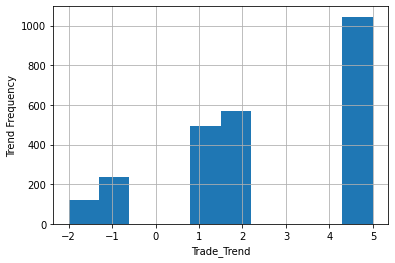

In [39]:
#user inputs to define TREND
x = (float(input("Enter price range(%) for a trend to be considered\n") or 5))/100
y = float(input("Enter target/stoploss ratio\n") or 2)
z = int(input("Enter the period for a trend\n") or 15)

# 1  : Bullish target without hitting stoploss (Uptrend)
# -1 : Bearish target without hitting stoploss (Downtrend)
# 0  : Price between Bullish and Bearish stoploss bound (Sidways- don't trade here)
# 2  : Price hitting both Bullish and Bearish target (Volatile)
# -2 : Price exceeding both Bullish and Bearish stoploss without reaching target (worst case)
#  5 : Trend period not sufficient to conclude a trend

High_array = np.array(stock_data['High'])
Low_array = np.array(stock_data['Low'])

#adding new attribute to store trend data
stock_data['Trade_Trend'] = np.nan

#function to detect Trade Trend category
def trend(df):
    for i in range(stock_data.shape[0]):
        Bull_target = stock_data.loc[stock_data.index[i],'Close']*(1+x)
        Bear_target = stock_data.loc[stock_data.index[i],'Close']*(1-x)
        Bull_stoploss = (stock_data.loc[stock_data.index[i],'Close']*(1-(x/y)))
        Bear_stoploss = (stock_data.loc[stock_data.index[i],'Close']*(1+(x/y)))
        Period_max = High_array[i:i+z].max()
        Period_min = Low_array[i:i+z].min()
        
        if((Period_min <= Bear_target)&
            (Period_max<Bear_stoploss)):
            stock_data.at[stock_data.index[i],'Trade_Trend'] = -1
        elif((Period_max >= Bull_target)&
          (Period_min > Bull_stoploss)):
            stock_data.at[stock_data.index[i],'Trade_Trend'] = 1
        elif((Period_max<Bear_stoploss)&
            (Period_min>Bull_stoploss)):
            stock_data.at[stock_data.index[i],'Trade_Trend'] = 0
        elif((Period_max >= Bear_stoploss)&
            (Period_max < Bull_target)&
            (Period_min <= Bull_stoploss)&
            (Period_min > Bear_target)):
            stock_data.at[stock_data.index[i],'Trade_Trend'] = -2
        elif((Period_max >= Bull_target)&
            (Period_min <= Bear_target)):
            stock_data.at[stock_data.index[i],'Trade_Trend'] = 2
        else:
            stock_data.at[stock_data.index[i],'Trade_Trend'] = 5

trend(stock_data)            
   
#plotting trend frequency
plt.hist(stock_data['Trade_Trend'])
plt.grid()
plt.xlabel("Trade_Trend")
plt.ylabel("Trend Frequency")
plt.show()

Aim 4: To check relation between RSI and trend

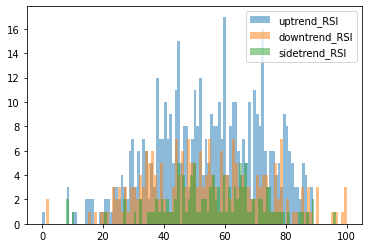

In [40]:
up_filt = (stock_data['Trade_Trend'] == 1)
down_filt = (stock_data['Trade_Trend'] == -1)
side_filt = ((stock_data['Trade_Trend'] == 0) | (stock_data['Trade_Trend'] == -2))
up_RSI = list(stock_data[up_filt]['Normalized_RSI'])
down_RSI = list(stock_data[down_filt]['Normalized_RSI'])
side_RSI = list(stock_data[side_filt]['Normalized_RSI'])
plt.hist(up_RSI, bins=100, alpha=0.5, label='uptrend_RSI')
plt.hist(down_RSI, bins=100, alpha=0.5, label='downtrend_RSI')
plt.hist(side_RSI, bins=100, alpha=0.5, label='sidetrend_RSI')

plt.legend(loc='upper right')
plt.show()

Inference: The histogram shows that there seems to be no difference in RSI values during an uptrend, downtrend or sidetrend.

Aim 5: To check relation between ADX value and Trade Trend.

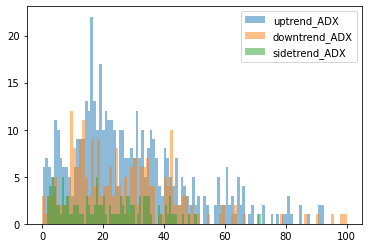

In [41]:
up_filt = (stock_data['Trade_Trend'] == 1)
down_filt = (stock_data['Trade_Trend'] == -1)
side_filt = ((stock_data['Trade_Trend'] == 0) | (stock_data['Trade_Trend'] == -2))
up_ADX = list(stock_data[up_filt]['Normalized_ADX'])
down_ADX = list(stock_data[down_filt]['Normalized_ADX'])
side_ADX = list(stock_data[side_filt]['Normalized_ADX'])
plt.hist(up_ADX, bins=100, alpha=0.5, label='uptrend_ADX')
plt.hist(down_ADX, bins=100, alpha=0.5, label='downtrend_ADX')
plt.hist(side_ADX, bins=100, alpha=0.5, label='sidetrend_ADX')

plt.legend(loc='upper right')
plt.show()

Inference: The histogram shows that there seems to be no difference in ADX values during an uptrend, downtrend or sidetrend.

MACHINE LEARNING MODELS

In [42]:
#keeping a backup of our indicator df before modifying it.
backup_stock_data_indicator_df = stock_data_indicator_df.copy()

MODEL 1: KNN

In [43]:
stock_data_indicator_df['Trade_Trend'] = np.nan
for i in range(stock_data_indicator_df.shape[0]):
    stock_data_indicator_df.at[stock_data_indicator_df.index[i],'Trade_Trend'] = stock_data.loc[stock_data_indicator_df.index[i],'Trade_Trend']
    
stock_data_indicator_df['Trade_Trend'] = stock_data_indicator_df['Trade_Trend'].replace(np.nan,10)
stock_data_indicator_df.dropna(inplace=True)
#X = stock_data_indicator_df[['RSI','ADX']]
#y = stock_data_indicator_df['Trade_Trend']

X = stock_data_indicator_df[['RSI_Slope','ADX_Slope']]
y = stock_data_indicator_df['Trade_Trend']

#Random Sampling
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#Sequential Sampling
train_index = int(0.8*len(X))
X_train,X_test = X[:train_index], X[train_index:]
y_train,y_test = y[:train_index], y[train_index:]

#KNN model
knn = neighbors.KNeighborsClassifier(n_neighbors=200,weights='uniform')
knn.fit(X_train,y_train)

train_prediction = knn.predict(X_train)
test_prediction = knn.predict(X_test)

accuracy_train = metrics.accuracy_score(y_train,train_prediction)
accuracy_test = metrics.accuracy_score(y_test,test_prediction)

#Checking overfitting

print("Train Accuracy:")
print(accuracy_train*100)
print("Test Accuracy:")
print(accuracy_test*100)

# 1: Comparing accuracy with label frequency

print("Label frequency to compare with accuracy")
print(stock_data_indicator_df['Trade_Trend'].value_counts()*100/stock_data_indicator_df['Trade_Trend'].count())

# 2: Comparing accuracy using Gambler test

gambler_prediction = np.random.choice([-2,-1,0,1,2], len(X_test))
gambler_accuracy = metrics.accuracy_score(gambler_prediction,y_test)
print("Gambler Accuracy:")
print(gambler_accuracy*100)

Train Accuracy:
41.390728476821195
Test Accuracy:
42.731277533039645
Label frequency to compare with accuracy
 5.0    41.438658
 2.0    23.742277
 1.0    20.917917
-1.0     9.399823
-2.0     4.501324
Name: Trade_Trend, dtype: float64
Gambler Accuracy:
9.691629955947137


In [44]:
knn.predict(X.tail(1))

array([5.])

Inference: The model does not seem to fit well owing to high difference in trend frequency. The highest trend frequency is category 5 and the KNN model seems to predict this category each time.

MODEL 2: XGBoost

Train Accuracy:
99.94481236203092
Test Accuracy:
54.18502202643172


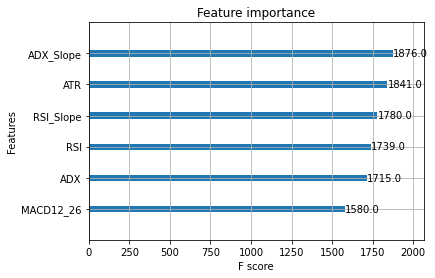

In [45]:
#XGB model

le = LabelEncoder()
y = le.fit_transform(y)
X = stock_data_indicator_df[['RSI_Slope','ADX_Slope','RSI','ADX','MACD12_26','ATR']]

#original trend ~ new trend
# -2 ~ 0
# -1 ~ 1
# 0 ~ 2
# 1 ~ 3
# 2 ~ 4
# 5 ~ 5

#Random Sampling
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# #Sequential Sampling
# train_index = int(0.8*len(X))
# X_train,X_test = X[:train_index], X[train_index:]
# y_train,y_test = y[:train_index], y[train_index:]

xgb = XGBClassifier()
xgb.fit(X_train,y_train)

train_prediction = xgb.predict(X_train)
test_prediction = xgb.predict(X_test)

accuracy_train = metrics.accuracy_score(y_train,train_prediction)
accuracy_test = metrics.accuracy_score(y_test,test_prediction)

print("Train Accuracy:")
print(accuracy_train*100)
print("Test Accuracy:")
print(accuracy_test*100)
plot_importance(xgb)
plt.show()

In [46]:
xgb.predict(X.tail(1))

array([4], dtype=int64)

Inference: The XGBoost model seems to fit way better than the KNN model as it is able to predict a larger variety of trends.

Creating Opportunity Universe

In [47]:
#importing NIFTY200 list from there website to create our opportunity universe.
oppor_univ = pd.read_csv("https://www1.nseindia.com/content/indices/ind_nifty200list.csv")
oppor_univ = oppor_univ[['Company Name','Symbol']]
oppor_univ_symbols = oppor_univ['Symbol'].tolist()
#displaying part of our opportunity universe list to see whehter we retrieved it successfully.
oppor_univ_symbols[::20]

['ABB',
 'DMART',
 'CANBK',
 'EMAMILTD',
 'HINDALCO',
 'IGL',
 'M&MFIN',
 'PAYTM',
 'SHREECEM',
 'TITAN']

Signal Detection- Checks our pattern dataframe to see if we encountered any candle/chart pattern today.

In [48]:
#patterns that a user wants to implement to filter down signals
patterns = stock_data_pattern_df.columns[7:]
t_patterns = []
for pattern in patterns:
    if((stock_data_pattern_df.loc[stock_data.tail(1).index[0],pattern] == 1)):
        t_patterns.append(pattern)
        
print("Pattern detected today:\n")
print(t_patterns)

Pattern detected today:

[]


Indicator confirmation- Checks our indicator dataframe to see how many of our indicators back our trade.

In [49]:
indicators_confirming = 0
indicators_confirmed = []

#Volume
total_indicators = 5
if((stock_data_indicator_df.loc[stock_data.tail(1).index[0],'Volume']) > (stock_data_indicator_df.loc[stock_data.tail(1).index[0],'Volume_SMA10'])):
    indicators_confirming += 1
    indicators_confirmed.append('Volume')
if((stock_data_indicator_df.loc[stock_data.tail(1).index[0],'EMA7'] > stock_data_indicator_df.loc[stock_data.tail(1).index[0],'EMA21'])):
    indicators_confirming += 1
    indicators_confirmed.append('EMA bull crossover')
if((stock_data_indicator_df.loc[stock_data.tail(1).index[0],'SMA50'] > stock_data_indicator_df.loc[stock_data.tail(1).index[0],'SMA200'])):
    indicators_confirming += 1
    indicators_confirmed.append('Golden Cross')
if((stock_data_indicator_df.loc[stock_data.tail(1).index[0],'MACD_Signal_9'] > stock_data_indicator_df.loc[stock_data.tail(1).index[0],'MACD12_26'])):
    indicators_confirming += 1
    indicators_confirmed.append('Bull MACD')
if((stock_data_indicator_df.loc[stock_data.tail(1).index[0],'Trend'] == 1)):
    indicators_confirming += 1
    indicators_confirmed.append('PSAR uptrend')
    
print(str(indicators_confirming)+'/'+str(total_indicators))
print(indicators_confirmed)

4/5
['Volume', 'EMA bull crossover', 'Golden Cross', 'PSAR uptrend']


Backtesting Randome Strategies

STRATERGY 1: Backtesting whether a candlestick pattern alone serves as a good Trading Signal for SWING trades:

In [50]:
def long_trade(j):
    i = j+1
    price = stock_data.loc[stock_data.index[i],'Open']
    target = price * (1+(target_p/100))
    stoploss = price * (1-(stoploss_p/100))
    Long_position_df.at[index,'StopLoss'] = stoploss
    Long_position_df.at[index,'Target'] = target
    max_period = i+max_holding_period
    while(price < target and price > stoploss and i<max_period):
        i += 1
        if(stock_data.loc[stock_data.index[i],'High'] > target):
            Long_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Long_position_df.at[index,'Exit_Price'] = target
            Long_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = target
        elif(stock_data.loc[stock_data.index[i],'Low'] < stoploss):
            Long_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Long_position_df.at[index,'Exit_Price'] = stoploss
            Long_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = stoploss
        else:
            Long_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Long_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
            Long_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = stock_data.loc[stock_data.index[i],'Close']
    Long_position_df.at[index,'P/L'] = Long_position_df.loc[index,'Exit_Price'] - Long_position_df.loc[index,'Entry_Price']

def Short_trade(j):
    i = j+1
    price = stock_data.loc[stock_data.index[i],'Open']
    target = price * (1-(target_p/100))
    stoploss = price * (1+(stoploss_p/100))
    Short_position_df.at[index,'StopLoss'] = stoploss
    Short_position_df.at[index,'Target'] = target
    max_period = i+max_holding_period
    while(price > target and price < stoploss and i<max_period):
        i += 1
        if(stock_data.loc[stock_data.index[i],'High'] > stoploss):
            Short_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Short_position_df.at[index,'Exit_Price'] = stoploss
            Short_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = stoploss
        elif(stock_data.loc[stock_data.index[i],'Low'] < target):
            Short_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Short_position_df.at[index,'Exit_Price'] = target
            Short_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = target
        else:
            Short_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Short_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
            Short_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = stock_data.loc[stock_data.index[i],'Close']
    Short_position_df.at[index,'P/L'] = Short_position_df.loc[index,'Entry_Price'] - Short_position_df.loc[index,'Exit_Price']

position = input("Enter Position(L/S)\n")
max_holding_period = int(input("Enter the maximum holding period of a position\n") or 28)

if(position == 'L'):
    target_p = float(input("Enter the target(in %) wrt Entry Price\n") or 7)
    stoploss_p = float(input("Enter the stoploss(in %) wrt Entry Price\n") or 2.5)
    Long_position_df = pd.DataFrame(columns = ['Entry_Date','Entry_Price','Exit_Date','Exit_Price','StopLoss','Target','Holding_Period','P/L'])
    
    #todo: provide user a list of patterns to select from
    filt = ((pattern_signal_df['Bull_Maru'] == 1) |
            (pattern_signal_df['Hammer'] == 1) |
            (pattern_signal_df['Bull_Engulf'] == 1) |
            (pattern_signal_df['Bull_Harami'] == 1) |
            (pattern_signal_df['Gap_Up'] == 1) |
           (pattern_signal_df['Morning_Star'] == 1))
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if((i+max_holding_period+1)<stock_data.shape[0]):
                Long_position_df.at[index,'Entry_Date'] = stock_data.index[i+1]
                Long_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                long_trade(i)
                index += 1
    print("Total Trades\t"+str(Long_position_df.shape[0]))
    print("Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] > Long_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] <= Long_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Long_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Long_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Long_position_df['P/L'].sum()))
    print("Average Holding Period\t"+ str(Long_position_df['Holding_Period'].mean()))
    print("Return(%)\t"+str((Long_position_df['P/L'].sum()/Long_position_df['Entry_Price'].sum())*100))
    display(Long_position_df.tail(5))
    
elif(position == 'S'):
    target_p = float(input("Enter the target(in %) wrt Entry Price\n") or 7)
    stoploss_p = float(input("Enter the stoploss(in %) wrt Entry Price\n") or 2.5)
    Short_position_df = pd.DataFrame(columns = ['Entry_Date','Entry_Price','Exit_Date','Exit_Price','StopLoss','Target','Holding_Period','P/L'])
    
    #todo: provide user a list of patterns to select from
    filt = (#(pattern_signal_df['Bear_Maru'] == 1) |
            (pattern_signal_df['Shooting_Star'] == 1) |
            (pattern_signal_df['Bear_Engulf'] == 1) |
            (pattern_signal_df['Bear_Harami'] == 1) |
            (pattern_signal_df['Gap_Down'] == 1) |
           (pattern_signal_df['Evening_Star'] == 1))
            
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if((i+max_holding_period+1)<stock_data.shape[0]):
                Short_position_df.at[index,'Entry_Date'] = stock_data.index[i+1]
                Short_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                Short_trade(i)
                index += 1
    print("Total Trades\t"+str(Short_position_df.shape[0]))
    print("Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] < Short_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] >= Short_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Short_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Short_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Short_position_df['P/L'].sum()))
    print("Average Holding Period\t"+ str(Short_position_df['Holding_Period'].mean()))
    print("Return(%)\t"+str((Short_position_df['P/L'].sum()/Short_position_df['Entry_Price'].sum())*100))
    display(Short_position_df.tail(5))
    

Enter Position(L/S)
L
Enter the maximum holding period of a position
50
Enter the target(in %) wrt Entry Price
5.5
Enter the stoploss(in %) wrt Entry Price
3
Total Trades	85
Profitable Trades	44
Non-Profitable Trades	41
Total Investment	172657.57460784912
Current Value	175294.2518576813
Net P/L	2636.6772498321466
Average Holding Period	2.0470588235294116
Return(%)	1.5271135690517694


Entry_Date Entry_Price            Exit_Date Exit_Price StopLoss  \
80  2022-03-10 00:00:00      7247.0  2022-03-11 00:00:00    7029.59  7029.59   
81  2022-03-17 00:00:00      7300.0  2022-03-23 00:00:00     7701.5   7081.0   
82  2022-03-21 00:00:00      7520.0  2022-03-25 00:00:00     7933.6   7294.4   
83  2022-04-21 00:00:00      7940.0  2022-04-22 00:00:00     8376.7   7701.8   
84  2022-05-16 00:00:00      7960.0  2022-05-18 00:00:00     8397.8   7721.2   

      Target Holding_Period     P/L  
80  7645.585              1 -217.41  
81    7701.5              3   401.5  
82    7933.6              4   413.6  
83    8376.7              1   436.7  
84    8397.8              2   437.8

Inference: The stock under study(TATAELXSI) only had a 1.527% return and this is without the brokerage cost included. Clearly trading in Long position in accordance with CandleStick Patterns alone wouldn't have been ideal.

STRATERGY 2: Modifying Strategy 1 to see whether swing trading based on Candlstick patterns in accordance to indicator confirmation improves our returns.

In [51]:
def long_indicator_confirmation(i):
    posi = Long_Indicator_confirmation.shape[0]
    Long_Indicator_confirmation.at[posi,'Date'] = stock_data.index[i]
    if(stock_data.index[i] in stock_data_indicator_df.index):
        #Volume Confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'Volume'] > stock_data_indicator_df.loc[stock_data.index[i],'Volume_SMA10'])):
            Long_Indicator_confirmation.at[posi,'Volume'] = 1
        else:
            Long_Indicator_confirmation.at[posi,'Volume'] = 0
        #Moving Average confirmation

        #RSI confirmation

        #MACD confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'MACD12_26'] > stock_data_indicator_df.loc[stock_data.index[i],'MACD_Signal_9'])):
            Long_Indicator_confirmation.at[posi,'MACD'] = 1
        else:
            Long_Indicator_confirmation.at[posi,'MACD'] = 0
        #ADX confirmation
        if(stock_data_indicator_df.loc[stock_data.index[i],'ADX'] > 25):
            if((stock_data_indicator_df.loc[stock_data.index[i],'plus_DI'] > stock_data_indicator_df.loc[stock_data.index[i],'minus_DI'])):
                Long_Indicator_confirmation.at[posi,'ADX'] = 1
            else:
                Long_Indicator_confirmation.at[posi,'ADX'] = 0

        #PSAR Trend confirmation

        if(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == 1):
            Long_Indicator_confirmation.at[posi,'PSAR_Trend'] = 1
        else:
            Long_Indicator_confirmation.at[posi,'PSAR_Trend'] = 0

        Indicators_confirmed = 0
        for column in Long_Indicator_confirmation.columns[1:]:
            if(Long_Indicator_confirmation.loc[posi,column] == 1):
                Indicators_confirmed += 1
        if(Indicators_confirmed >= 1):
            return 1
              
def short_indicator_confirmation(i):
    posi = Short_Indicator_confirmation.shape[0]
    Short_Indicator_confirmation.at[posi,'Date'] = stock_data.index[i]
    if(stock_data.index[i] in stock_data_indicator_df.index):
        #Volume Confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'Volume'] > stock_data_indicator_df.loc[stock_data.index[i],'Volume_SMA10'])):
            Short_Indicator_confirmation.at[posi,'Volume'] = 1
        else:
            Short_Indicator_confirmation.at[posi,'Volume'] = 0
        #Moving Average confirmation

        #RSI confirmation

        #MACD confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'MACD12_26'] < stock_data_indicator_df.loc[stock_data.index[i],'MACD_Signal_9'])):
            Short_Indicator_confirmation.at[posi,'MACD'] = 1
        else:
            Short_Indicator_confirmation.at[posi,'MACD'] = 0
        #ADX confirmation
        if(stock_data_indicator_df.loc[stock_data.index[i],'ADX'] > 25):
            if((stock_data_indicator_df.loc[stock_data.index[i],'plus_DI'] < stock_data_indicator_df.loc[stock_data.index[i],'minus_DI'])):
                Short_Indicator_confirmation.at[posi,'ADX'] = 1
            else:
                Short_Indicator_confirmation.at[posi,'ADX'] = 0

        #PSAR Trend confirmation

        if(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == -1):
            Short_Indicator_confirmation.at[posi,'PSAR_Trend'] = 1
        else:
            Short_Indicator_confirmation.at[posi,'PSAR_Trend'] = 0

        Indicators_confirmed = 0
        for column in Short_Indicator_confirmation.columns[1:]:
            if(Short_Indicator_confirmation.loc[posi,column] == 1):
                Indicators_confirmed += 1
        if(Indicators_confirmed >= 4):
            return 1
                     
def long_trade(j):
    i = j+1
    price = stock_data.loc[stock_data.index[i],'Open']
    target = price * (1+(target_p/100))
    stoploss = price * (1-(stoploss_p/100))
    Long_position_df.at[index,'StopLoss'] = stoploss
    Long_position_df.at[index,'Target'] = target
    max_period = i+max_holding_period
    while(price < target and price > stoploss and i<max_period):
        i += 1
        if(stock_data.loc[stock_data.index[i],'High'] > target):
            Long_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Long_position_df.at[index,'Exit_Price'] = target
            Long_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = target
        elif(stock_data.loc[stock_data.index[i],'Low'] < stoploss):
            Long_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Long_position_df.at[index,'Exit_Price'] = stoploss
            Long_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = stoploss
        else:
            Long_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Long_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
            Long_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = stock_data.loc[stock_data.index[i],'Close']
    Long_position_df.at[index,'P/L'] = Long_position_df.loc[index,'Exit_Price'] - Long_position_df.loc[index,'Entry_Price']

def Short_trade(j):
    i = j+1
    price = stock_data.loc[stock_data.index[i],'Open']
    target = price * (1-(target_p/100))
    stoploss = price * (1+(stoploss_p/100))
    Short_position_df.at[index,'StopLoss'] = stoploss
    Short_position_df.at[index,'Target'] = target
    max_period = i+max_holding_period
    while(price > target and price < stoploss and i<max_period):
        i += 1
        if(stock_data.loc[stock_data.index[i],'High'] > stoploss):
            Short_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Short_position_df.at[index,'Exit_Price'] = stoploss
            Short_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = stoploss
        elif(stock_data.loc[stock_data.index[i],'Low'] < target):
            Short_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Short_position_df.at[index,'Exit_Price'] = target
            Short_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = target
        else:
            Short_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Short_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
            Short_position_df.at[index,'Holding_Period'] = (i - (max_period-max_holding_period))
            price = stock_data.loc[stock_data.index[i],'Close']
    Short_position_df.at[index,'P/L'] = Short_position_df.loc[index,'Entry_Price'] - Short_position_df.loc[index,'Exit_Price']
    
position = input("Enter Position(L/S)\n")
max_holding_period = int(input("Enter the maximum holding period of a position\n") or 28)

if(position == 'L'):
    target_p = float(input("Enter the target(in %) wrt Entry Price\n") or 7)
    stoploss_p = float(input("Enter the stoploss(in %) wrt Entry Price\n") or 2.5)
    Long_position_df = pd.DataFrame(columns = ['Entry_Date','Entry_Price','Exit_Date','Exit_Price','StopLoss','Target','Holding_Period','P/L'])
    
    #creating a Long position Indicator confirmation df:
    Long_Indicator_confirmation = pd.DataFrame(columns=['Date','Volume','Moving_Average','RSI','MACD','ADX','PSAR_trend'])
    
    #todo: provide user a list of patterns to select from
    filt = ((pattern_signal_df['Bull_Maru'] == 1) |
            (pattern_signal_df['Hammer'] == 1) |
            (pattern_signal_df['Bull_Engulf'] == 1) |
            (pattern_signal_df['Bull_Harami'] == 1) |
            (pattern_signal_df['Gap_Up'] == 1) |
           (pattern_signal_df['Morning_Star'] == 1))
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if((i+max_holding_period+1)<stock_data.shape[0]):
                indicator_confirmation = long_indicator_confirmation(i)                    
                if(indicator_confirmation == 1):
                    Long_position_df.at[index,'Entry_Date'] = stock_data.index[i+1]
                    Long_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                    long_trade(i)
                    index += 1
    print("Total Trades\t"+str(Long_position_df.shape[0]))
    print("Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] > Long_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] <= Long_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Long_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Long_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Long_position_df['P/L'].sum()))
    print("Average Holding Period\t"+ str(Long_position_df['Holding_Period'].mean()))
    print("Return(%)\t"+str((Long_position_df['P/L'].sum()/Long_position_df['Entry_Price'].sum())*100))
    display(Long_position_df.tail(5))
    
elif(position == 'S'):
    target_p = float(input("Enter the target(in %) wrt Entry Price\n") or 7)
    stoploss_p = float(input("Enter the stoploss(in %) wrt Entry Price\n") or 2.5)
    Short_position_df = pd.DataFrame(columns = ['Entry_Date','Entry_Price','Exit_Date','Exit_Price','StopLoss','Target','Holding_Period','P/L'])
    
    #creating a short position Indicator confirmation df:
    Short_Indicator_confirmation = pd.DataFrame(columns=['Date','Volume','Moving_Average','RSI','MACD','ADX','PSAR_trend'])
    
    #todo: provide user a list of patterns to select from
    filt = ((pattern_signal_df['Bear_Maru'] == 1) |
            (pattern_signal_df['Shooting_Star'] == 1) |
            (pattern_signal_df['Bear_Engulf'] == 1) |
            (pattern_signal_df['Bear_Harami'] == 1) |
            (pattern_signal_df['Gap_Down'] == 1) |
           (pattern_signal_df['Evening_Star'] == 1))
            
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if((i+max_holding_period+1)<stock_data.shape[0]):
                indicator_confirmation = short_indicator_confirmation(i)
                if(indicator_confirmation == 1):
                    Short_position_df.at[index,'Entry_Date'] = stock_data.index[i+1]
                    Short_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                    Short_trade(i)
                    index += 1
    print("Total Trades\t"+str(Short_position_df.shape[0]))
    print("Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] < Short_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] >= Short_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Short_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Short_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Short_position_df['P/L'].sum()))
    print("Average Holding Period\t"+ str(Short_position_df['Holding_Period'].mean()))
    print("Return(%)\t"+str((Short_position_df['P/L'].sum()/Short_position_df['Entry_Price'].sum())*100))
    display(Short_position_df.tail(5))

Enter Position(L/S)
L
Enter the maximum holding period of a position
50
Enter the target(in %) wrt Entry Price
5.5
Enter the stoploss(in %) wrt Entry Price
3
Total Trades	71
Profitable Trades	38
Non-Profitable Trades	33
Total Investment	158212.0497894287
Current Value	160399.55054950714
Net P/L	2187.5007600784243
Average Holding Period	1.8873239436619718
Return(%)	1.3826385303710205


Entry_Date Entry_Price            Exit_Date Exit_Price StopLoss  \
66  2022-03-10 00:00:00      7247.0  2022-03-11 00:00:00    7029.59  7029.59   
67  2022-03-17 00:00:00      7300.0  2022-03-23 00:00:00     7701.5   7081.0   
68  2022-03-21 00:00:00      7520.0  2022-03-25 00:00:00     7933.6   7294.4   
69  2022-04-21 00:00:00      7940.0  2022-04-22 00:00:00     8376.7   7701.8   
70  2022-05-16 00:00:00      7960.0  2022-05-18 00:00:00     8397.8   7721.2   

      Target Holding_Period     P/L  
66  7645.585              1 -217.41  
67    7701.5              3   401.5  
68    7933.6              4   413.6  
69    8376.7              1   436.7  
70    8397.8              2   437.8

Inference: There seemed to be no improvement in Strategy 1 even after taking indicators into account.

STRATERGY 3: Using candlestick pattern to enter a trade and PSAR to exit rather than fixed target and stoploss.

In [57]:
def long_indicator_confirmation(i):
    posi = Long_Indicator_confirmation.shape[0]
    Long_Indicator_confirmation.at[posi,'Date'] = stock_data.index[i]
    if(stock_data.index[i] in stock_data_indicator_df.index):
        #Volume Confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'Volume'] > stock_data_indicator_df.loc[stock_data.index[i],'Volume_SMA10'])):
            Long_Indicator_confirmation.at[posi,'Volume'] = 1
        else:
            Long_Indicator_confirmation.at[posi,'Volume'] = 0
        #Moving Average confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'EMA7'] > stock_data_indicator_df.loc[stock_data.index[i],'EMA21'])):
            Long_Indicator_confirmation.at[posi,'MA'] = 1
        else:
            Long_Indicator_confirmation.at[posi,'MA'] = 0

        #RSI confirmation

        #MACD confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'MACD12_26'] > stock_data_indicator_df.loc[stock_data.index[i],'MACD_Signal_9'])):
            Long_Indicator_confirmation.at[posi,'MACD'] = 1
        else:
            Long_Indicator_confirmation.at[posi,'MACD'] = 0
        #ADX confirmation
        if(stock_data_indicator_df.loc[stock_data.index[i],'ADX'] > 25):
            if((stock_data_indicator_df.loc[stock_data.index[i],'plus_DI'] > stock_data_indicator_df.loc[stock_data.index[i],'minus_DI'])):
                Long_Indicator_confirmation.at[posi,'ADX'] = 1
            else:
                Long_Indicator_confirmation.at[posi,'ADX'] = 0

        #PSAR prior Trend confirmation

        if((stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == 1)&
          ((stock_data_indicator_df.loc[stock_data.index[i-1],'Trend'] == -1) | (stock_data_indicator_df.loc[stock_data.index[i-2],'Trend'] == -1))):
            Long_Indicator_confirmation.at[posi,'PSAR_Trend'] = 1
        else:
            Long_Indicator_confirmation.at[posi,'PSAR_Trend'] = 0

        Indicators_confirmed = 0
        for column in Long_Indicator_confirmation.columns[1:]:
            if(Long_Indicator_confirmation.loc[posi,column] == 1):
                Indicators_confirmed += 1
        if(Indicators_confirmed >= 4):
            return 1
        
        
def short_indicator_confirmation(i):
    posi = Short_Indicator_confirmation.shape[0]
    Short_Indicator_confirmation.at[posi,'Date'] = stock_data.index[i]
    if(stock_data.index[i] in stock_data_indicator_df.index):
        #Volume Confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'Volume'] > stock_data_indicator_df.loc[stock_data.index[i],'Volume_SMA10'])):
            Short_Indicator_confirmation.at[posi,'Volume'] = 1
        else:
            Short_Indicator_confirmation.at[posi,'Volume'] = 0
        #Moving Average confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'EMA7'] < stock_data_indicator_df.loc[stock_data.index[i],'EMA21'])):
            Short_Indicator_confirmation.at[posi,'MA'] = 1
        else:
            Short_Indicator_confirmation.at[posi,'MA'] = 0

        #RSI confirmation

        #MACD confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'MACD12_26'] < stock_data_indicator_df.loc[stock_data.index[i],'MACD_Signal_9'])):
            Short_Indicator_confirmation.at[posi,'MACD'] = 1
        else:
            Short_Indicator_confirmation.at[posi,'MACD'] = 0
        #ADX confirmation
        if(stock_data_indicator_df.loc[stock_data.index[i],'ADX'] > 25):
            if((stock_data_indicator_df.loc[stock_data.index[i],'plus_DI'] < stock_data_indicator_df.loc[stock_data.index[i],'minus_DI'])):
                Short_Indicator_confirmation.at[posi,'ADX'] = 1
            else:
                Short_Indicator_confirmation.at[posi,'ADX'] = 0

        #PSAR Trend confirmation

        if((stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == -1)&
          ((stock_data_indicator_df.loc[stock_data.index[i-1],'Trend'] == 1) | (stock_data_indicator_df.loc[stock_data.index[i-2],'Trend'] == 1))):
            Short_Indicator_confirmation.at[posi,'PSAR_Trend'] = 1
        else:
            Short_Indicator_confirmation.at[posi,'PSAR_Trend'] = 0

        Indicators_confirmed = 0
        for column in Short_Indicator_confirmation.columns[1:]:
            if(Short_Indicator_confirmation.loc[posi,column] == 1):
                Indicators_confirmed += 1
        if(Indicators_confirmed >= 4):
            return 1
                  
def long_trade(j):
    i = j+1
    price = stock_data.loc[stock_data.index[i],'Open']
    if(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == 1):
        while(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] != -1 and i < (stock_data.shape[0]-1)):
            i += 1
            Long_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Long_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
            Long_position_df.at[index,'Holding_Period'] = (i-j-1)
        Long_position_df.at[index,'P/L'] = Long_position_df.loc[index,'Exit_Price'] - Long_position_df.loc[index,'Entry_Price']
    elif(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == -1):
        Long_position_df.at[index,'Exit_Date'] = stock_data.index[i]
        Long_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
        Long_position_df.at[index,'Holding_Period'] = (i-j-1)
        Long_position_df.at[index,'P/L'] = Long_position_df.loc[index,'Exit_Price'] - Long_position_df.loc[index,'Entry_Price']
        
def Short_trade(j):
    i = j+1
    price = stock_data.loc[stock_data.index[i],'Open']
    if(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == -1):
        while(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] != 1 and i < (stock_data.shape[0]-1)):
            i += 1
            Short_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Short_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
            Short_position_df.at[index,'Holding_Period'] = (i-j-1)       
        Short_position_df.at[index,'P/L'] = Short_position_df.loc[index,'Entry_Price'] - Short_position_df.loc[index,'Exit_Price']
    elif(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == 1):
        Short_position_df.at[index,'Exit_Date'] = stock_data.index[i]
        Short_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
        Short_position_df.at[index,'Holding_Period'] = (i-j-1)       
        Short_position_df.at[index,'P/L'] = Short_position_df.loc[index,'Entry_Price'] - Short_position_df.loc[index,'Exit_Price']
    
position = (input("Enter Position(L/S)\n"))

if(position == 'L'):
    Long_position_df = pd.DataFrame(columns = ['Entry_Date','Entry_Price','Exit_Date','Exit_Price','Holding_Period','P/L'])
    
    #creating a Long position Indicator confirmation df:
    Long_Indicator_confirmation = pd.DataFrame(columns=['Date','Volume','MA','RSI','MACD','ADX','PSAR_trend'])
    
    #todo: provide user a list of patterns to select from
    filt = ((pattern_signal_df['Bull_Maru'] == 1) |
             (pattern_signal_df['Hammer'] == 1) |
             (pattern_signal_df['Bull_Engulf'] == 1) |
            (pattern_signal_df['Bull_Harami'] == 1) |
            (pattern_signal_df['Gap_Up'] == 1) |
           (pattern_signal_df['Morning_Star'] == 1)
           )
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if(i<stock_data.shape[0]-2):
                indicator_confirmation = long_indicator_confirmation(i)                    
                if(indicator_confirmation == 1):
                    if(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == 1):
                        Long_position_df.at[index,'Entry_Date'] = stock_data.index[i+1]
                        Long_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                        long_trade(i)
                        index += 1
    print("Total Trades\t"+str(Long_position_df.shape[0]))
    print("Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] > Long_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] <= Long_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Long_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Long_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Long_position_df['P/L'].sum()))
    print("Average Holding Period\t"+ str(Long_position_df['Holding_Period'].mean()))
    print("Return(%)\t"+str((Long_position_df['P/L'].sum()/Long_position_df['Entry_Price'].sum())*100))
    display(Long_position_df.tail(5))
    
elif(position == 'S'):
    Short_position_df = pd.DataFrame(columns = ['Entry_Date','Entry_Price','Exit_Date','Exit_Price','Holding_Period','P/L'])
    
    #creating a short position Indicator confirmation df:
    Short_Indicator_confirmation = pd.DataFrame(columns=['Date','Volume','MA','RSI','MACD','ADX','PSAR_trend'])
    
    #todo: provide user a list of patterns to select from
    filt = ((pattern_signal_df['Bear_Maru'] == 1) |
            (pattern_signal_df['Shooting_Star'] == 1) |
            (pattern_signal_df['Bear_Engulf'] == 1) |
            (pattern_signal_df['Bear_Harami'] == 1) |
            (pattern_signal_df['Gap_Down'] == 1) |
           (pattern_signal_df['Evening_Star'] == 1))
            
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if((i+1)<stock_data.shape[0]):
                indicator_confirmation = short_indicator_confirmation(i)
                if(indicator_confirmation == 1):
                    if(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == -1):
                        Short_position_df.at[index,'Entry_Date'] = stock_data.index[i+1]
                        Short_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                        Short_trade(i)
                        index += 1
                    
    print("Total Trades\t"+str(Short_position_df.shape[0]))
    print("Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] < Short_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] >= Short_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Short_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Short_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Short_position_df['P/L'].sum()))
    print("Average Holding Period\t"+ str(Short_position_df['Holding_Period'].mean()))
    print("Return(%)\t"+str((Short_position_df['P/L'].sum()/Short_position_df['Entry_Price'].sum())*100))
    display(Short_position_df.tail(5))

Enter Position(L/S)
L
Total Trades	21
Profitable Trades	10
Non-Profitable Trades	11
Total Investment	54521.24983215332
Current Value	52976.12480163574
Net P/L	-1545.1250305175781
Average Holding Period	9.476190476190476
Return(%)	-2.833986812984535


Entry_Date Entry_Price            Exit_Date   Exit_Price  \
16  2021-07-16 00:00:00      4390.0  2021-07-19 00:00:00  4223.350098   
17  2021-10-18 00:00:00      6315.0  2021-10-22 00:00:00  6032.299805   
18  2022-01-20 00:00:00      7059.0  2022-01-27 00:00:00  6974.149902   
19  2022-01-21 00:00:00      7520.0  2022-01-27 00:00:00  6974.149902   
20  2022-02-01 00:00:00      7779.0  2022-02-14 00:00:00  6911.350098   

   Holding_Period         P/L  
16              1 -166.649902  
17              4 -282.700195  
18              4  -84.850098  
19              3 -545.850098  
20              9 -867.649902

Inference: We cannot comment upon PSAR indicator performance as the average holding period is very less which is bound to minimize our profits since it takes time for PSAR to set according to the trend.

STRATERGY 4: Using PSAR confirmation before entering a trade and exiting in accordance to PSAR reversal.

In [58]:
def long_indicator_confirmation(i):
    posi = Long_Indicator_confirmation.shape[0]
    Long_Indicator_confirmation.at[posi,'Date'] = stock_data.index[i]
    if(stock_data.index[i] in stock_data_indicator_df.index):
        #Volume Confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'Volume'] > stock_data_indicator_df.loc[stock_data.index[i],'Volume_SMA10'])):
            Long_Indicator_confirmation.at[posi,'Volume'] = 1
        else:
            Long_Indicator_confirmation.at[posi,'Volume'] = 0
        #Moving Average confirmation

        #RSI confirmation

        #MACD confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'MACD12_26'] > stock_data_indicator_df.loc[stock_data.index[i],'MACD_Signal_9'])):
            Long_Indicator_confirmation.at[posi,'MACD'] = 1
        else:
            Long_Indicator_confirmation.at[posi,'MACD'] = 0
        #ADX confirmation
        if(stock_data_indicator_df.loc[stock_data.index[i],'ADX'] > 25):
            if((stock_data_indicator_df.loc[stock_data.index[i],'plus_DI'] > stock_data_indicator_df.loc[stock_data.index[i],'minus_DI'])):
                Long_Indicator_confirmation.at[posi,'ADX'] = 1
            else:
                Long_Indicator_confirmation.at[posi,'ADX'] = 0

        #PSAR prior Trend confirmation

        if(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == 1):
            Long_Indicator_confirmation.at[posi,'PSAR_Trend'] = 1
        else:
            Long_Indicator_confirmation.at[posi,'PSAR_Trend'] = 0

        Indicators_confirmed = 0
        for column in Long_Indicator_confirmation.columns[1:]:
            if(Long_Indicator_confirmation.loc[posi,column] == 1):
                Indicators_confirmed += 1
        if(Indicators_confirmed >= 4):
            return 1
        
        
def short_indicator_confirmation(i):
    posi = Short_Indicator_confirmation.shape[0]
    Short_Indicator_confirmation.at[posi,'Date'] = stock_data.index[i]
    if(stock_data.index[i] in stock_data_indicator_df.index):
        #Volume Confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'Volume'] > stock_data_indicator_df.loc[stock_data.index[i],'Volume_SMA10'])):
            Short_Indicator_confirmation.at[posi,'Volume'] = 1
        else:
            Short_Indicator_confirmation.at[posi,'Volume'] = 0
        #Moving Average confirmation

        #RSI confirmation

        #MACD confirmation
        if((stock_data_indicator_df.loc[stock_data.index[i],'MACD12_26'] < stock_data_indicator_df.loc[stock_data.index[i],'MACD_Signal_9'])):
            Short_Indicator_confirmation.at[posi,'MACD'] = 1
        else:
            Short_Indicator_confirmation.at[posi,'MACD'] = 0
        #ADX confirmation
        if(stock_data_indicator_df.loc[stock_data.index[i],'ADX'] > 25):
            if((stock_data_indicator_df.loc[stock_data.index[i],'plus_DI'] < stock_data_indicator_df.loc[stock_data.index[i],'minus_DI'])):
                Short_Indicator_confirmation.at[posi,'ADX'] = 1
            else:
                Short_Indicator_confirmation.at[posi,'ADX'] = 0

        #PSAR Trend confirmation

        if(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == -1):
            Long_Indicator_confirmation.at[posi,'PSAR_Trend'] = 1
        else:
            Long_Indicator_confirmation.at[posi,'PSAR_Trend'] = 0

        Indicators_confirmed = 0
        for column in Long_Indicator_confirmation.columns[1:]:
            if(Long_Indicator_confirmation.loc[posi,column] == 1):
                Indicators_confirmed += 1
        if(Indicators_confirmed >= 4):
            return 1
        
                
def long_trade(j):
    i = j+1
    price = stock_data.loc[stock_data.index[i],'Open']
    if(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == 1):
        while(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] != -1 and i < (stock_data.shape[0]-1)):
            i += 1
            Long_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Long_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
            Long_position_df.at[index,'Holding_Period'] = (i-j-1)
        Long_position_df.at[index,'P/L'] = Long_position_df.loc[index,'Exit_Price'] - Long_position_df.loc[index,'Entry_Price']
    elif(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == -1):
        Long_position_df.at[index,'Exit_Date'] = stock_data.index[i]
        Long_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
        Long_position_df.at[index,'Holding_Period'] = (i-j-1)
        Long_position_df.at[index,'P/L'] = Long_position_df.loc[index,'Exit_Price'] - Long_position_df.loc[index,'Entry_Price']
        

def Short_trade(j):
    i = j+1
    price = stock_data.loc[stock_data.index[i],'Open']
    if(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == -1):
        while(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] != 1 and i < (stock_data.shape[0]-1)):
            i += 1
            Short_position_df.at[index,'Exit_Date'] = stock_data.index[i]
            Short_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
            Short_position_df.at[index,'Holding_Period'] = (i-j-1)       
        Short_position_df.at[index,'P/L'] = Short_position_df.loc[index,'Entry_Price'] - Short_position_df.loc[index,'Exit_Price']
    elif(stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == 1):
        Short_position_df.at[index,'Exit_Date'] = stock_data.index[i]
        Short_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i],'Close']
        Short_position_df.at[index,'Holding_Period'] = (i-j-1)       
        Short_position_df.at[index,'P/L'] = Short_position_df.loc[index,'Entry_Price'] - Short_position_df.loc[index,'Exit_Price']
    
position = input("Enter Position(L/S)\n")

if(position == 'L'):
    Long_position_df = pd.DataFrame(columns = ['Entry_Date','Entry_Price','Exit_Date','Exit_Price','Holding_Period','P/L'])
    
    #creating a Long position Indicator confirmation df:
    Long_Indicator_confirmation = pd.DataFrame(columns=['Date','Volume','Moving_Average','RSI','MACD','ADX','PSAR_trend'])
    
    #todo: provide user a list of patterns to select from
    filt = ((pattern_signal_df['Bull_Maru'] == 1) |
            (pattern_signal_df['Hammer'] == 1) |
            (pattern_signal_df['Bull_Engulf'] == 1) |
            (pattern_signal_df['Bull_Harami'] == 1) |
            (pattern_signal_df['Gap_Up'] == 1) |
           (pattern_signal_df['Morning_Star'] == 1))
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if(i<stock_data.shape[0]-2):
                indicator_confirmation = long_indicator_confirmation(i)                    
                if(indicator_confirmation == 1):
                    Long_position_df.at[index,'Entry_Date'] = stock_data.index[i+1]
                    Long_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                    long_trade(i)
                    index += 1
    print("Total Trades\t"+str(Long_position_df.shape[0]))
    print("Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] > Long_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] <= Long_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Long_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Long_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Long_position_df['P/L'].sum()))
    print("Average Holding Period\t"+ str(Long_position_df['Holding_Period'].mean()))
    print("Return(%)\t"+str((Long_position_df['P/L'].sum()/Long_position_df['Entry_Price'].sum())*100))
    display(Long_position_df.tail(5))
    
elif(position == 'S'):
    Short_position_df = pd.DataFrame(columns = ['Entry_Date','Entry_Price','Exit_Date','Exit_Price','Holding_Period','P/L'])
    
    #creating a short position Indicator confirmation df:
    Short_Indicator_confirmation = pd.DataFrame(columns=['Date','Volume','Moving_Average','RSI','MACD','ADX','PSAR_trend'])
    
    #todo: provide user a list of patterns to select from
    filt = ((pattern_signal_df['Bear_Maru'] == 1) |
            (pattern_signal_df['Shooting_Star'] == 1) |
            (pattern_signal_df['Bear_Engulf'] == 1) |
            (pattern_signal_df['Bear_Harami'] == 1) |
            (pattern_signal_df['Gap_Down'] == 1) |
           (pattern_signal_df['Evening_Star'] == 1))
            
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if((i+1)<stock_data.shape[0]):
                indicator_confirmation = short_indicator_confirmation(i)
                if(indicator_confirmation == 1):
                    Short_position_df.at[index,'Entry_Date'] = stock_data.index[i+1]
                    Short_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                    Short_trade(i)
                    index += 1
    print("Total Trades\t"+str(Short_position_df.shape[0]))
    print("Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] < Short_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] >= Short_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Short_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Short_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Short_position_df['P/L'].sum()))
    print("Average Holding Period\t"+ str(Short_position_df['Holding_Period'].mean()))
    print("Return(%)\t"+str((Short_position_df['P/L'].sum()/Short_position_df['Entry_Price'].sum())*100))
    
    display(Short_position_df.tail(5))

Enter Position(L/S)
L
Total Trades	18
Profitable Trades	10
Non-Profitable Trades	8
Total Investment	42873.64985656738
Current Value	42221.32469177246
Net P/L	-652.3251647949219
Average Holding Period	9.833333333333334
Return(%)	-1.5215060228771233


Entry_Date  Entry_Price            Exit_Date   Exit_Price  \
13  2021-05-05 00:00:00  3895.899902  2021-05-10 00:00:00  3613.149902   
14  2021-07-16 00:00:00       4390.0  2021-07-19 00:00:00  4223.350098   
15  2021-10-18 00:00:00       6315.0  2021-10-22 00:00:00  6032.299805   
16  2022-01-20 00:00:00       7059.0  2022-01-27 00:00:00  6974.149902   
17  2022-01-21 00:00:00       7520.0  2022-01-27 00:00:00  6974.149902   

   Holding_Period         P/L  
13              3     -282.75  
14              1 -166.649902  
15              4 -282.700195  
16              4  -84.850098  
17              3 -545.850098

Failed. PSAR Should work for long term trends and non volatile stocks. Since the average holding period is only 10 days, this strategy does not yield good returns as it takes time for PSAR to set according to the trend and 10 days aren't enough. Another option is to modify PSAR parameters to decrease whipsaws in trend pattern in volatile stocks.

STRATERGY 5: Testing whether candlestick patterns serves as a good indicator for intraday trades the next day.

In [59]:
position = input("Enter Position(L/S)\n")

if(position == 'L'):
    Long_position_df = pd.DataFrame(columns = ['Date','Entry_Price','Exit_Price','P/L'])
    
    #todo: provide user a list of patterns to select from
    filt = ((pattern_signal_df['Bull_Maru'] == 1) |
            (pattern_signal_df['Hammer'] == 1) |
            (pattern_signal_df['Bull_Engulf'] == 1) |
            (pattern_signal_df['Bull_Harami'] == 1) |
            (pattern_signal_df['Gap_Up'] == 1) |
           (pattern_signal_df['Morning_Star'] == 1))
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if(i<stock_data.shape[0]-1):
                Long_position_df.at[index,'Date'] = stock_data.index[i+1]
                Long_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                Long_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i+1],'Close']
                Long_position_df.at[index,'P/L'] = Long_position_df.loc[index,'Exit_Price'] - Long_position_df.loc[index,'Entry_Price']
                index += 1
    print("Total Trades\t"+str(Long_position_df.shape[0]))
    print("Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] > Long_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] <= Long_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Long_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Long_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Long_position_df['P/L'].sum()))
    print("Return(%)\t"+str((Long_position_df['P/L'].sum()/Long_position_df['Entry_Price'].sum())*100))
    display(Long_position_df.tail(5))
    
elif(position == 'S'):
    Short_position_df = pd.DataFrame(columns = ['Date','Entry_Price','Exit_Price','P/L'])
    
    #todo: provide user a list of patterns to select from
    filt = ((pattern_signal_df['Bear_Maru'] == 1) |
            (pattern_signal_df['Shooting_Star'] == 1) |
            (pattern_signal_df['Bear_Engulf'] == 1) |
            (pattern_signal_df['Bear_Harami'] == 1) |
            (pattern_signal_df['Gap_Down'] == 1) |
           (pattern_signal_df['Evening_Star'] == 1))
            
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if(i<stock_data.shape[0]-1):
                Short_position_df.at[index,'Date'] = stock_data.index[i+1]
                Short_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                Short_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i+1],'Close']
                Short_position_df.at[index,'P/L'] = Short_position_df.loc[index,'Entry_Price'] - Short_position_df.loc[index,'Exit_Price']
                index += 1
    print("Total Trades\t"+str(Short_position_df.shape[0]))
    print("Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] < Short_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] >= Short_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Short_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Short_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Short_position_df['P/L'].sum()))
    print("Return(%)\t"+str((Short_position_df['P/L'].sum()/Short_position_df['Entry_Price'].sum())*100))
    display(Short_position_df.tail(5))

Enter Position(L/S)
L
Total Trades	89
Profitable Trades	41
Non-Profitable Trades	48
Total Investment	205872.97451019287
Current Value	205301.62522888184
Net P/L	-571.3492813110352
Return(%)	-0.2775251499961921


Date  Entry_Price   Exit_Price         P/L
84  2022-05-16 00:00:00       7960.0  8121.149902  161.149902
85  2022-06-01 00:00:00       8612.0       8606.0        -6.0
86  2022-06-28 00:00:00       7958.0  8036.700195   78.700195
87  2022-07-18 00:00:00  8100.399902  8104.049805    3.649902
88  2022-07-28 00:00:00       8545.0       8560.0        15.0

Even intraday trades following a candlestick patterns does not seem to work too well. Might need to make the patterns parameter more stricts.

STRATERGY 6 : Modifying strategy 5 to include indicator confirmation before executing Intraday trades based on candlestick patterns.

In [60]:
def long_indicator_confirmation(j):
    i = j+1
    if(stock_data.index[i] in stock_data_indicator_df.index):
        if((stock_data_indicator_df.loc[stock_data.index[i],'Volume'] > stock_data_indicator_df.loc[stock_data.index[i],'Volume_SMA10']) &
          (stock_data_indicator_df.loc[stock_data.index[i],'plus_DI'] > stock_data_indicator_df.loc[stock_data.index[i],'minus_DI']) &
          (stock_data_indicator_df.loc[stock_data.index[i],'ADX'] >25) &
          (stock_data_indicator_df.loc[stock_data.index[i],'MACD12_26'] > stock_data_indicator_df.loc[stock_data.index[i],'MACD_Signal_9'])&
          (stock_data_indicator_df.loc[stock_data.index[i],'Trend'] ==1)):
            return 1
    
    
def short_indicator_confirmation(j):
    i = j+1
    if(stock_data.index[i] in stock_data_indicator_df.index):
        if((stock_data_indicator_df.loc[stock_data.index[i],'Volume'] > stock_data_indicator_df.loc[stock_data.index[i],'Volume_SMA10']) &
          (stock_data_indicator_df.loc[stock_data.index[i],'plus_DI'] < stock_data_indicator_df.loc[stock_data.index[i],'minus_DI']) &
          (stock_data_indicator_df.loc[stock_data.index[i],'ADX'] > 25) &
          (stock_data_indicator_df.loc[stock_data.index[i],'MACD12_26'] < stock_data_indicator_df.loc[stock_data.index[i],'MACD_Signal_9']) &
          (stock_data_indicator_df.loc[stock_data.index[i],'Trend'] == -1)):
            return 1
    
    
position = input("Enter Position(L/S)\n")

if(position == 'L'):
    Long_position_df = pd.DataFrame(columns = ['Date','Entry_Price','Exit_Price','P/L'])
    
    #todo: provide user a list of patterns to select from
    filt = ((pattern_signal_df['Bull_Maru'] == 1) |
            (pattern_signal_df['Hammer'] == 1) |
            (pattern_signal_df['Bull_Engulf'] == 1) |
            (pattern_signal_df['Bull_Harami'] == 1) |
            (pattern_signal_df['Gap_Up'] == 1) |
           (pattern_signal_df['Morning_Star'] == 1))
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if(i<stock_data.shape[0]-1):
                indicator_confirmation = long_indicator_confirmation(i)
                if(indicator_confirmation == 1):
                    Long_position_df.at[index,'Date'] = stock_data.index[i+1]
                    Long_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                    Long_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i+1],'Close']
                    Long_position_df.at[index,'P/L'] = Long_position_df.loc[index,'Exit_Price'] - Long_position_df.loc[index,'Entry_Price']
                    index += 1
    print("Total Trades\t"+str(Long_position_df.shape[0]))
    print("Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] > Long_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Long_position_df[(Long_position_df['Exit_Price'] <= Long_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Long_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Long_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Long_position_df['P/L'].sum()))
    print("Return(%)\t"+str((Long_position_df['P/L'].sum()/Long_position_df['Entry_Price'].sum())*100))
    display(Long_position_df.tail(5))
    
elif(position == 'S'):
    Short_position_df = pd.DataFrame(columns = ['Date','Entry_Price','Exit_Price','P/L'])
    
    #todo: provide user a list of patterns to select from
    filt = ((pattern_signal_df['Bear_Maru'] == 1) |
            (pattern_signal_df['Shooting_Star'] == 1) |
            (pattern_signal_df['Bear_Engulf'] == 1) |
            (pattern_signal_df['Bear_Harami'] == 1) |
            (pattern_signal_df['Gap_Down'] == 1) |
           (pattern_signal_df['Evening_Star'] == 1))
            
    temp_signal_df = pattern_signal_df[filt]
    
    index = 0
    for i in range(stock_data.shape[0]):
        if(stock_data.index[i] in temp_signal_df.index):
            if(i<stock_data.shape[0]-1):
                indicator_confirmation = short_indicator_confirmation(i)
                if(indicator_confirmation == 1):
                    Short_position_df.at[index,'Date'] = stock_data.index[i+1]
                    Short_position_df.at[index,'Entry_Price'] = stock_data.loc[stock_data.index[i+1],'Open']
                    Short_position_df.at[index,'Exit_Price'] = stock_data.loc[stock_data.index[i+1],'Close']
                    Short_position_df.at[index,'P/L'] = Short_position_df.loc[index,'Entry_Price'] - Short_position_df.loc[index,'Exit_Price']
                    index += 1
    print("Total Trades\t"+str(Short_position_df.shape[0]))
    print("Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] < Short_position_df['Entry_Price'])].shape[0]))
    print("Non-Profitable Trades\t"+str(Short_position_df[(Short_position_df['Exit_Price'] >= Short_position_df['Entry_Price'])].shape[0]))
    print("Total Investment\t"+str(Short_position_df['Entry_Price'].sum()))
    print("Current Value\t"+str(Short_position_df['Exit_Price'].sum()))
    print("Net P/L\t"+str(Short_position_df['P/L'].sum()))
    print("Return(%)\t"+str((Short_position_df['P/L'].sum()/Short_position_df['Entry_Price'].sum())*100))
    display(Short_position_df.tail(5))

Enter Position(L/S)
L
Total Trades	17
Profitable Trades	12
Non-Profitable Trades	5
Total Investment	40368.27494049072
Current Value	40853.27536010742
Net P/L	485.0004196166992
Return(%)	1.2014395470989712


Date Entry_Price   Exit_Price         P/L
12  2021-02-01 00:00:00     2711.75  2949.800049  238.050049
13  2021-07-16 00:00:00      4390.0  4302.649902  -87.350098
14  2021-11-10 00:00:00      6270.0  6410.149902  140.149902
15  2022-01-20 00:00:00      7059.0  7430.450195  371.450195
16  2022-01-21 00:00:00      7520.0  7200.700195 -319.299805

The results for intraday trade based on indicator confirmation increased drastically in comparison to swing trades based on candlestick and indicator confirmation. One reason may be that for swing trades, since the period is more, there are more chances of indicators changing in the meantime whereas we only take indicator confirmation during entry. 
One option is to base our exit strategy based on indicator confirmations in swing trade and see the results.

The above strategy gives us 2:1 ratio for successful/non-successful trades. Modifying this strategy with better exit strategy to minimize loss could give good returns as this is an intraday trade and we could use margins additionally, though brokerage cost would also increase.

STRATERGY 7 : Trial testing a stratergy with PSAR alone for entry and exit without any other indicator or pattern

In [61]:
PSAR_trading_df = pd.DataFrame(columns = ['Position','Entry_Date','Entry_Price','Exit_Date','Exit_Price','Holding_Period','P/L'])

def long_trade(i):
    posi = PSAR_trading_df.shape[0]
    PSAR_trading_df.at[posi,'Position'] = 'Long'
    PSAR_trading_df.at[posi,'Entry_Date'] = stock_data_indicator_df.index[i+1]
    PSAR_trading_df.at[posi,'Entry_Price'] = stock_data_indicator_df.loc[stock_data_indicator_df.index[i+1],'Open']
    global entry
    entry = i
    
def short_trade(i):
    posi = PSAR_trading_df.shape[0]
    PSAR_trading_df.at[posi,'Position'] = 'Short'
    PSAR_trading_df.at[posi,'Entry_Date'] = stock_data_indicator_df.index[i+1]
    PSAR_trading_df.at[posi,'Entry_Price'] = stock_data_indicator_df.loc[stock_data_indicator_df.index[i+1],'Open']
    global entry
    entry = i
    
def exit(i,position):
    if(position == 1):
        long_exit(i)
    elif(position == -1):
        short_exit(i)
    
def long_exit(i):
    posi = PSAR_trading_df.shape[0]-1
    PSAR_trading_df.at[posi,'Exit_Date'] = stock_data_indicator_df.index[i+1]
    PSAR_trading_df.at[posi,'Exit_Price'] = stock_data_indicator_df.loc[stock_data_indicator_df.index[i+1],'Open']
    PSAR_trading_df.at[posi,'Holding_Period'] = i-entry
    PSAR_trading_df.at[posi,'P/L'] = PSAR_trading_df.loc[posi,'Exit_Price'] - PSAR_trading_df.loc[posi,'Entry_Price']
    
def short_exit(i):
    posi = PSAR_trading_df.shape[0]-1
    PSAR_trading_df.at[posi,'Exit_Date'] = stock_data_indicator_df.index[i+1]
    PSAR_trading_df.at[posi,'Exit_Price'] = stock_data_indicator_df.loc[stock_data_indicator_df.index[i+1],'Open']
    PSAR_trading_df.at[posi,'Holding_Period'] = i-entry
    PSAR_trading_df.at[posi,'P/L'] = PSAR_trading_df.loc[posi,'Entry_Price'] - PSAR_trading_df.loc[posi,'Exit_Price']
    

#placing an initial trade before executing the loop based on initial trade
index = 0 
Prior_Trend = stock_data_indicator_df.loc[stock_data_indicator_df.index[index],'Trend']
if(Prior_Trend == -1):
    short_trade(0)
elif(Prior_Trend == 1):
    long_trade(0)

#loop for rest of the trades
for i in range(1,stock_data_indicator_df.shape[0]-1):
    Current_Trend = stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'Trend']
    
    if(Current_Trend == Prior_Trend):
        Prior_Trend = Current_Trend
    elif(Current_Trend != Prior_Trend):
        exit(i,Prior_Trend)
        if(Current_Trend == 1):
            long_trade(i)
            Prior_Trend = 1
        elif(Current_Trend == -1):
            short_trade(i)
            Prior_Trend = -1
    
print("Total Trades\t"+str(PSAR_trading_df.shape[0]))
print("Profitable Trades\t"+str(PSAR_trading_df[(PSAR_trading_df['P/L']>0)].shape[0]))
print("Non-Profitable Trades\t"+str(PSAR_trading_df[(PSAR_trading_df['P/L']<0)].shape[0]))
print("Net P/L\t"+str(PSAR_trading_df['P/L'].sum())) 
print("Average Holding Period\t"+ str(PSAR_trading_df['Holding_Period'].mean()))
print("Return(%)\t"+str((PSAR_trading_df['P/L'].sum()/PSAR_trading_df['Entry_Price'].sum())*100))
display(PSAR_trading_df.tail(5))

Total Trades	330
Profitable Trades	108
Non-Profitable Trades	219
Net P/L	5763.499160766602
Average Holding Period	6.838905775075988
Return(%)	1.3950465506007779


Position           Entry_Date  Entry_Price            Exit_Date  \
325     Long  2022-05-16 00:00:00       7960.0  2022-06-15 00:00:00   
326    Short  2022-06-15 00:00:00       8475.0  2022-06-28 00:00:00   
327     Long  2022-06-28 00:00:00       7958.0  2022-07-13 00:00:00   
328    Short  2022-07-13 00:00:00       8004.0  2022-07-18 00:00:00   
329     Long  2022-07-18 00:00:00  8100.399902                  NaN   

      Exit_Price Holding_Period        P/L  
325       8475.0             22      515.0  
326       7958.0              9      517.0  
327       8004.0             11       46.0  
328  8100.399902              3 -96.399902  
329          NaN            NaN        NaN

No major returns although the strategy seems decent. May try combining with other strategies to improve it.
The average hoolding period is only 6 day whereas PSAR is such that it requires a few day to set in accordance to the trend itself.

STRATERGY 8 : Backtesting stratergy using Ichimoku alone

In [62]:
ichimoku_df = ichimoku_df.drop(['Chikou'],axis=1)
ichimoku_df.dropna(inplace=True)

ichimoku_trading_df = pd.DataFrame(columns=['Position','Entry_Date','Entry_Price','Exit_Date','Exit_Price','Holding_Period','P/L'])

def senkou_check(i):
    if((ichimoku_df.loc[ichimoku_df.index[i],'Senkou_A'] > ichimoku_df.loc[ichimoku_df.index[i],'Senkou_B'])):
        return 1
    elif((ichimoku_df.loc[ichimoku_df.index[i],'Senkou_A'] < ichimoku_df.loc[ichimoku_df.index[i],'Senkou_B'])):
        return -1
    
def price_check(i):
    if(ichimoku_df.loc[ichimoku_df.index[i],'Low'] > ichimoku_df.loc[ichimoku_df.index[i],'Senkou_A']):
        return 1
    elif(ichimoku_df.loc[ichimoku_df.index[i],'High'] < ichimoku_df.loc[ichimoku_df.index[i],'Senkou_A']):
        return -1

def Tenkan_and_Kijun_check(i):
    if(ichimoku_df.loc[ichimoku_df.index[i],'Kijun_San'] > ichimoku_df.loc[ichimoku_df.index[i],'Senkou_A']):
        if(ichimoku_df.loc[ichimoku_df.index[i],'Tenkan_San'] > ichimoku_df.loc[ichimoku_df.index[i],'Kijun_San']):
            return 1  
    elif(ichimoku_df.loc[ichimoku_df.index[i],'Kijun_San'] < ichimoku_df.loc[ichimoku_df.index[i],'Senkou_A']):
        if(ichimoku_df.loc[ichimoku_df.index[i],'Tenkan_San'] < ichimoku_df.loc[ichimoku_df.index[i],'Kijun_San']):
            return -1

global t_day

def long_trade(i):
    t_day = i
    posi = ichimoku_trading_df.shape[0]-1
    while((ichimoku_df.loc[ichimoku_df.index[i],'Tenkan_San']>ichimoku_df.loc[ichimoku_df.index[i],'Kijun_San'])&
         (i<ichimoku_df.shape[0]-1)):
        ichimoku_trading_df.at[posi,'Exit_Price'] = ichimoku_df.loc[ichimoku_df.index[i+1],'Open']
        ichimoku_trading_df.at[posi,'Exit_Date'] = stock_data.index[ichimoku_df.index[i+1]] 
        ichimoku_trading_df.at[posi,'P/L'] = ichimoku_trading_df.loc[posi,'Exit_Price'] - ichimoku_trading_df.loc[posi,'Entry_Price']
        i += 1
        start = i
    ichimoku_trading_df.at[posi,'Holding_Period'] = start - t_day
    search(start)
    
def short_trade(i):
    t_day = i
    posi = ichimoku_trading_df.shape[0]-1
    while((ichimoku_df.loc[ichimoku_df.index[i],'Tenkan_San']<ichimoku_df.loc[ichimoku_df.index[i],'Kijun_San'])&
         (i<ichimoku_df.shape[0]-1)):
        ichimoku_trading_df.at[posi,'Exit_Price'] = ichimoku_df.loc[ichimoku_df.index[i+1],'Open']
        ichimoku_trading_df.at[posi,'Exit_Date'] = stock_data.index[ichimoku_df.index[i]] 
        ichimoku_trading_df.at[posi,'P/L'] = ichimoku_trading_df.loc[posi,'Entry_Price'] - ichimoku_trading_df.loc[posi,'Exit_Price']
        i += 1
        start = i
    ichimoku_trading_df.at[posi,'Holding_Period'] = start - t_day
    search(start)

def search(start):
    for i in range(start,ichimoku_df.shape[0]-1):
        if((senkou_check(i) == 1)&
          (price_check(i) == 1)&
          (Tenkan_and_Kijun_check(i) == 1)):
            index = ichimoku_trading_df.shape[0]
            ichimoku_trading_df.at[index,'Entry_Price'] = ichimoku_df.loc[ichimoku_df.index[i],'Close']
            ichimoku_trading_df.at[index,'Entry_Date'] = stock_data.index[ichimoku_df.index[i]]
            ichimoku_trading_df.at[index,'Position'] = 'Long'
            long_trade(i)
            break
#         elif((senkou_check(i) == -1)&
#           (price_check(i) == -1)&
#           (Tenkan_and_Kijun_check(i) == -1)):
#             index = ichimoku_trading_df.shape[0]
#             ichimoku_trading_df.at[index,'Entry_Price'] = ichimoku_df.loc[ichimoku_df.index[i],'Close']
#             ichimoku_trading_df.at[index,'Entry_Date'] = stock_data.index[ichimoku_df.index[i]]
#             ichimoku_trading_df.at[index,'Position'] = 'Short'
#             short_trade(i)
#             break
            
global start
start = 0       
search(start)

print("Total Trades\t"+str(ichimoku_trading_df.shape[0]))
print("Profitable Trades\t"+str(ichimoku_trading_df[(ichimoku_trading_df['P/L']>0)].shape[0]))
print("Non-Profitable Trades\t"+str(ichimoku_trading_df[(ichimoku_trading_df['P/L']<0)].shape[0]))
print("Total Investment\t" + str(ichimoku_trading_df['Entry_Price'].sum()))
print("Current Value\t" + str(ichimoku_trading_df['Exit_Price'].sum()))
print("Net P/L\t"+str(ichimoku_trading_df['P/L'].sum()))
print("Average Holding Period\t"+ str(ichimoku_trading_df['Holding_Period'].mean()))
print("Return(%)\t" + str((ichimoku_trading_df['P/L'].sum()/ichimoku_trading_df['Entry_Price'].sum())*100))
ichimoku_trading_df.tail(5)

Total Trades	36
Profitable Trades	18
Non-Profitable Trades	18
Total Investment	67303.05052947998
Current Value	70364.84999084473
Net P/L	3061.799461364746
Average Holding Period	21.13888888888889
Return(%)	4.549272933807988


Position           Entry_Date  Entry_Price            Exit_Date  \
31     Long  2021-08-17 00:00:00      4715.25  2021-11-01 00:00:00   
32     Long  2021-11-12 00:00:00      6552.75  2021-11-29 00:00:00   
33     Long  2022-02-21 00:00:00       6733.0  2022-02-22 00:00:00   
34     Long  2022-03-25 00:00:00  8438.200195  2022-04-25 00:00:00   
35     Long  2022-07-27 00:00:00  8481.400391  2022-08-05 00:00:00   

     Exit_Price Holding_Period         P/L  
31       5900.0             51     1184.75  
32       5600.0             10     -952.75  
33  6422.899902              1 -310.100098  
34       8319.0             19 -119.200195  
35       8953.0              7  471.599609

This strategy based on ichimoku seems to work very well with a 4.55% return for long position. Manually exiting position to minimize loss would render it a practical working trading strategy.

STRATERGY 9 : Backtesting strategy to trade solely based on EMA(7x21) signals. Should work for long term trends.

In [63]:
EMA_trading_df = pd.DataFrame(columns=['Position','Entry_Date','Entry_Price','Exit_Date','Exit_Price','Holding_Period','P/L'])

global t_day

def long_trade(i):
    t_day = i
    posi = EMA_trading_df.shape[0]-1
    while((stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'EMA7']>stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'EMA21'])&
         (i < stock_data_indicator_df.shape[0]-1)):
        i += 1
        EMA_trading_df.at[posi,'Exit_Date'] = stock_data_indicator_df.index[i]
        EMA_trading_df.at[posi,'Exit_Price'] = stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'Open']
        EMA_trading_df.at[posi,'P/L'] = EMA_trading_df.loc[posi,'Exit_Price'] - EMA_trading_df.loc[posi,'Entry_Price']
        start = i
    EMA_trading_df.at[posi,'Holding_Period'] = start - t_day
    search(start)
    
def short_trade(i):
    t_day = i
    posi = EMA_trading_df.shape[0]-1
    while((stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'EMA7']<stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'EMA21'])&
         (i < stock_data_indicator_df.shape[0]-1)):
        i += 1
        EMA_trading_df.at[posi,'Exit_Date'] = stock_data_indicator_df.index[i]
        EMA_trading_df.at[posi,'Exit_Price'] = stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'Open']
        EMA_trading_df.at[posi,'P/L'] = EMA_trading_df.loc[posi,'Entry_Price'] - EMA_trading_df.loc[posi,'Exit_Price']
        start = i
    EMA_trading_df.at[posi,'Holding_Period'] = start - t_day
    search(start)

def search(start):
    for i in range(start, stock_data_indicator_df.shape[0]-1):
        if(stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'EMA7'] > stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'EMA21']):
            index = EMA_trading_df.shape[0]
            EMA_trading_df.at[index,'Position'] = 'Long'
            EMA_trading_df.at[index,'Entry_Date'] = stock_data_indicator_df.index[i]
            EMA_trading_df.at[index,'Entry_Price'] = stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'Close']
            long_trade(i)
            break
#         elif(stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'EMA7'] < stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'EMA21']):
#             index = EMA_trading_df.shape[0]
#             EMA_trading_df.at[index,'Position'] = 'Short'
#             EMA_trading_df.at[index,'Entry_Date'] = stock_data_indicator_df.index[i]
#             EMA_trading_df.at[index,'Entry_Price'] = stock_data_indicator_df.loc[stock_data_indicator_df.index[i],'Close']
#             short_trade(i)
#             break
            
global start
start = 0
search(start)
            
print("Total Trades\t"+str(EMA_trading_df.shape[0]))
print("Profitable Trades\t"+str(EMA_trading_df[(EMA_trading_df['P/L']>0)].shape[0]))
print("Non-Profitable Trades\t"+str(EMA_trading_df[(EMA_trading_df['P/L']<0)].shape[0]))
print("Total Investment\t" + str(EMA_trading_df['Entry_Price'].sum()))
print("Current Value\t" + str(EMA_trading_df['Exit_Price'].sum()))
print("Net P/L\t"+str(EMA_trading_df['P/L'].sum()))
print("Return(%)\t" + str((EMA_trading_df['P/L'].sum()/EMA_trading_df['Entry_Price'].sum())*100))
EMA_trading_df.tail(5)

Total Trades	50
Profitable Trades	25
Non-Profitable Trades	24
Total Investment	64863.55009460449
Current Value	73505.07539367676
Net P/L	8641.525299072266
Return(%)	13.322621543946433


Position           Entry_Date  Entry_Price            Exit_Date  \
45     Long  2021-04-01 00:00:00       2772.0  2021-11-25 00:00:00   
46     Long  2022-01-04 00:00:00      5977.75  2022-02-21 00:00:00   
47     Long  2022-03-11 00:00:00  7121.200195  2022-04-20 00:00:00   
48     Long  2022-05-18 00:00:00  8437.700195  2022-06-16 00:00:00   
49     Long  2022-07-20 00:00:00  8113.799805  2022-08-05 00:00:00   

     Exit_Price Holding_Period         P/L  
45       6020.0            160      3248.0  
46       6915.0             33      937.25  
47  7777.950195             25      656.75  
48       8340.0             21  -97.700195  
49       8953.0             12  839.200195

As expected, a whooping 12.81% return for tata elxsi. However, this is not enough to conclude EMA as a good trading strategy for TATAELXSI has major long term bullish trend and thus the high return. Such may not be the case for a stock with volatile price. The returns could again be increased by manually exiting the trade as it takes longer for EMA to reverse back. Time periods other than 7x21 could be tested to see which works better.

Backtesting trading strategy based on CHART patterns.

Exit stratergy 1: fixed target and stoploss based on Chart Pattern(ex: for double bottom, period low would act as stoploss and period high as target)

In [64]:
#creating df to store trade details
double_triangle_df = pd.DataFrame(columns=['Position','Entry_Date','Entry_Price','Exit_Date','Exit_Price','Holding_Period','P/L'])

#creating df of those entries where we got a double_top/double_bottom signal
temp_df = stock_data_pattern_df.copy()
temp_df.reset_index(inplace=True)
signal_df = temp_df[temp_df['Double_Top/Double_Bottom'] == 1]

#user input for strategy parameters
x = float(input("Enter allowable variation(%) between tops or bottoms of triangle pattern\n")or 5)/100
y = float(input("Enter margin in target and stoploss(%)\n") or 1.5)/100

def data(i):
    end = (signal_df.index[i])+1
    mid = end-14
    start = mid-14
    first_period_max = second_period_max = 0
    first_period_min = second_period_min = 100000
    dicts = {}
    tempo = i
    
    #storing two period's high and low to set them as target and stoploss
    for i in range(start,mid):
        if(temp_df.loc[temp_df.index[i],'High']>first_period_max):
            first_period_max = temp_df.loc[temp_df.index[i],'High']
        if(temp_df.loc[temp_df.index[i],'Low']<first_period_min):
            first_period_min = temp_df.loc[temp_df.index[i],'Low']
    for i in range(mid,end):
        if(temp_df.loc[temp_df.index[i],'High']>second_period_max):
            second_period_max = temp_df.loc[temp_df.index[i],'High']
        if(temp_df.loc[temp_df.index[i],'Low']<second_period_min):
            second_period_min = temp_df.loc[temp_df.index[i],'Low']
            
    #1 implies a double bottom pattern        
    if((first_period_min*(1-x)<=second_period_min<=first_period_min*(1+x)) or
      (second_period_min*(1-x)<=first_period_min<=second_period_min*(1+x))):
        dicts['stoploss'] = min(first_period_min,second_period_min)
        dicts['target'] = max(first_period_max,second_period_max)
        dicts['posi'] = 1
        return dicts
    #-1 implies a double top pattern
    elif((first_period_max*(1-x)<=second_period_max<=first_period_max*(1+x)) or
        (second_period_max*(1-x)<=first_period_max<=second_period_max*(1+x))):
        dicts['stoploss'] = max(first_period_max,second_period_max)
        dicts['target'] = min(first_period_min,second_period_min)
        dicts['posi'] = -1
        return dicts
    #2 implies a zig-zag pattern(refer to README file on github)
    elif((first_period_max == max(first_period_max,second_period_max)) &
        (second_period_min == min(first_period_min,second_period_min))):
        dicts['target'] = first_period_max
        dicts['stoploss'] = second_period_min
        dicts['posi'] = 2
        return dicts
    #-2 implies a zag-zig pattern(refer to README file on github)
    elif((first_period_min == min(first_period_min,second_period_min)) &
        (second_period_max == max(first_period_max,second_period_max))):
        dicts['target'] = first_period_min
        dicts['stoploss'] = second_period_max
        dicts['posi'] = -2
        return dicts
    #for other signals
    else:
        pass

#function to execute a trade
def trade(i,posi,target,stoploss):
    price = temp_df.loc[temp_df.index[[(signal_df.index[i])+1]],'Open'].item()
    index = (signal_df.index[i])+1
    start = index
    if(posi>0):
        while((price < target) & (price > stoploss) & (index<temp_df.shape[0])):
            index += 1
            double_triangle_df.at[i,'Exit_Date'] = temp_df.loc[index,'Date']
            double_triangle_df.at[i,'Exit_Price'] = temp_df.loc[index,'Close'].item()
            double_triangle_df.at[i,'P/L'] = double_triangle_df.loc[i,'Exit_Price'] - double_triangle_df.loc[i,'Entry_Price']
            double_triangle_df.at[i,'Holding_Period'] = index-start
            price = temp_df.loc[index,'Close']       
    elif(posi<0):
        while((price > target) & (price < stoploss) & (index<temp_df.shape[0])):
            index += 1
            double_triangle_df.at[i,'Exit_Date'] = temp_df.loc[index,'Date']
            double_triangle_df.at[i,'Exit_Price'] = temp_df.loc[index,'Close'].item()
            double_triangle_df.at[i,'P/L'] = double_triangle_df.loc[i,'Entry_Price'] - double_triangle_df.loc[i,'Exit_Price']
            double_triangle_df.at[i,'Holding_Period'] = index-start
            price = temp_df.loc[index,'Close']     
        
for i in range(signal_df.shape[0]):
    datas = data(i)
    try:
        posi = datas['posi']
        if(posi>0):
            target = (datas['target'])*(1-y)
            stoploss = (datas['stoploss'])*(1+y)
        elif(posi<0):
            target = (datas['target'])*(1+y)
            stoploss = (datas['stoploss'])*(1-y)
        double_triangle_df.at[i,'Entry_Date'] = temp_df.loc[temp_df.index[[(signal_df.index[i])+1]],'Date'].item()
        double_triangle_df.at[i,'Entry_Price'] = temp_df.loc[temp_df.index[[(signal_df.index[i])+1]],'Open'].item()
        double_triangle_df.at[i,'Position'] = posi
        trade(i,posi,target,stoploss)
    except:
        pass
    
print("Total Trades\t"+str(double_triangle_df.shape[0]))
print("Profitable Trades\t"+str(double_triangle_df[(double_triangle_df['P/L']>0)].shape[0]))
print("Non-Profitable Trades\t"+str(double_triangle_df[(double_triangle_df['P/L']<0)].shape[0]))
print("Total Investment\t" + str(double_triangle_df['Entry_Price'].sum()))
print("Current Value\t" + str(double_triangle_df['Exit_Price'].sum()))
print("Net P/L\t"+str(double_triangle_df['P/L'].sum()))
print("Return(%)\t" + str((double_triangle_df['P/L'].sum()/double_triangle_df['Entry_Price'].sum())*100))
double_triangle_df.tail(5)

Enter allowable variation(%) between tops or bottoms of triangle pattern

Enter margin in target and stoploss(%)

Total Trades	47
Profitable Trades	23
Non-Profitable Trades	19
Total Investment	56121.37496948242
Current Value	55700.374855041504
Net P/L	2469.1502532958984
Return(%)	4.399661010868976


Position           Entry_Date  Entry_Price            Exit_Date  \
46        1  2020-12-15 00:00:00       1600.0  2020-12-23 00:00:00   
47        1  2022-01-06 00:00:00       5873.0  2022-01-12 00:00:00   
48        2  2022-03-10 00:00:00       7247.0  2022-03-25 00:00:00   
49       -1  2022-06-09 00:00:00       8595.0  2022-07-29 00:00:00   
50        2  2022-07-06 00:00:00  8035.899902  2022-07-29 00:00:00   

     Exit_Price Holding_Period          P/L  
46  1786.099976              6   186.099976  
47  6114.100098              4   241.100098  
48  8438.200195             10  1191.200195  
49  8690.049805             36   -95.049805  
50  8690.049805             17   654.149902

A decent returns with a simple Chart Pattern strategy. Chart patterns seems to do well for swing trades rather than candlestick patterns which happened to work well for intraday trading in accordance to other indicators.

Exit stratergy 2- Trailing target in order to reap in on the additional profits when the stock moves beyond our target.

In [65]:
#creating df to store trade details
double_triangle_df = pd.DataFrame(columns=['Position','Entry_Date','Entry_Price','Exit_Date','Exit_Price','Target','StopLoss','Holding_Period','P/L'])

#creating df of those entries where we got a double_top/double_bottom signal
temp_df = stock_data_pattern_df.copy()
temp_df.reset_index(inplace=True)
signal_df = temp_df[temp_df['Double_Top/Double_Bottom'] == 1]

x = float(input("Enter allowable variation(%) between tops or bottoms of triangle pattern\n")or 5)/100
y = float(input("Enter margin for target(%)\n") or 2)/100
z = float(input("Enter margin for stoploss(%)\n") or 1.5)/100

def data(i):
    end = (signal_df.index[i])+1
    mid = end-14
    start = mid-14
    first_period_max = second_period_max = 0
    first_period_min = second_period_min = 100000
    dicts = {}
    tempo = i
    for i in range(start,mid):
        if(temp_df.loc[temp_df.index[i],'High']>first_period_max):
            first_period_max = temp_df.loc[temp_df.index[i],'High']
        if(temp_df.loc[temp_df.index[i],'Low']<first_period_min):
            first_period_min = temp_df.loc[temp_df.index[i],'Low']
    for i in range(mid,end):
        if(temp_df.loc[temp_df.index[i],'High']>second_period_max):
            second_period_max = temp_df.loc[temp_df.index[i],'High']
        if(temp_df.loc[temp_df.index[i],'Low']<second_period_min):
            second_period_min = temp_df.loc[temp_df.index[i],'Low']
    if((first_period_min*(1-x)<=second_period_min<=first_period_min*(1+x)) or
      (second_period_min*(1-x)<=first_period_min<=second_period_min*(1+x))):
        dicts['stoploss'] = min(first_period_min,second_period_min)
        dicts['target'] = max(first_period_max,second_period_max)
        dicts['posi'] = 1
        return dicts
    elif((first_period_max*(1-x)<=second_period_max<=first_period_max*(1+x)) or
        (second_period_max*(1-x)<=first_period_max<=second_period_max*(1+x))):
        dicts['stoploss'] = max(first_period_max,second_period_max)
        dicts['target'] = min(first_period_min,second_period_min)
        dicts['posi'] = -1
        return dicts
    elif((first_period_max == max(first_period_max,second_period_max)) &
        (second_period_min == min(first_period_min,second_period_min))):
        dicts['target'] = first_period_max
        dicts['stoploss'] = second_period_min
        dicts['posi'] = 2
        return dicts
    elif((first_period_min == min(first_period_min,second_period_min)) &
        (second_period_max == max(first_period_max,second_period_max))):
        dicts['target'] = first_period_min
        dicts['stoploss'] = second_period_max
        dicts['posi'] = -2
        return dicts
    else:
        pass

def trade(i,posi,target,stoploss):
    key = 0
    peak = pit =  0
    price = temp_df.loc[temp_df.index[[(signal_df.index[i])+1]],'Open'].item()
    index = (signal_df.index[i])+1
    start = index
    if(posi>0):
        while((price < target) & (price > stoploss) & (index<temp_df.shape[0])):
            index += 1
            double_triangle_df.at[i,'Exit_Date'] = temp_df.loc[index,'Date']
            double_triangle_df.at[i,'Exit_Price'] = temp_df.loc[index,'Close'].item()
            double_triangle_df.at[i,'P/L'] = double_triangle_df.loc[i,'Exit_Price'] - double_triangle_df.loc[i,'Entry_Price']
            double_triangle_df.at[i,'Holding_Period'] = index-start
            price = temp_df.loc[index,'Close']       
            if(price>=target):
                og_target = target
                target = og_target*2
                key = 1
            if(key == 1):
                peak = max(peak,price)
                surplus_profit = peak-og_target
                stoploss = og_target + (surplus_profit*0.5)
                
    elif(posi<0):
        while((price > target) & (price < stoploss) & (index<temp_df.shape[0])):
            index += 1
            double_triangle_df.at[i,'Exit_Date'] = temp_df.loc[index,'Date']
            double_triangle_df.at[i,'Exit_Price'] = temp_df.loc[index,'Close'].item()
            double_triangle_df.at[i,'P/L'] = double_triangle_df.loc[i,'Entry_Price'] - double_triangle_df.loc[i,'Exit_Price']
            double_triangle_df.at[i,'Holding_Period'] = index-start
            price = temp_df.loc[index,'Close']   
            if(price<target):
                og_target = target
                target = og_target*0.5
                key = 1
            if(key == 1):
                pit = min(pit,price)
                surplus_profit = og_target-pit
                stoploss = og_target-(surplus_profit*0.5)
#         if((((peak-og_target)/og_target)*100)<=10):
#                     stoploss = og_target + (peak-og_target)*0.5
#                 if((((peak-og_target)/og_target)*100)>10):
#                     stoploss = peak*0.9
for i in range(signal_df.shape[0]):
    datas = data(i)
    try:
        posi = datas['posi']
        if(posi>0):
            target = (datas['target'])*(1-y)
            stoploss = (datas['stoploss'])*(1+z)
        elif(posi<0):
            target = (datas['target'])*(1+y)
            stoploss = (datas['stoploss'])*(1-z)
        double_triangle_df.at[i,'Entry_Date'] = temp_df.loc[temp_df.index[[(signal_df.index[i])+1]],'Date'].item()
        double_triangle_df.at[i,'Entry_Price'] = temp_df.loc[temp_df.index[[(signal_df.index[i])+1]],'Open'].item()
        double_triangle_df.at[i,'Position'] = posi
        gain = ((target-double_triangle_df.loc[i,'Entry_Price'])/double_triangle_df.at[i,'Entry_Price'])*100
        loss = (abs(stoploss-double_triangle_df.at[i,'Entry_Price'])/double_triangle_df.at[i,'Entry_Price'])*100
        #todo- enter condition that gain/loss ratio should be greater than (1.4?)
        double_triangle_df.at[i,'Target'] = target
        double_triangle_df.at[i,'StopLoss'] = stoploss 
        trade(i,posi,target,stoploss)
    except:
        continue
    
print("Total Trades\t"+str(double_triangle_df.shape[0]))
print("Profitable Trades\t"+str(double_triangle_df[(double_triangle_df['P/L']>0)].shape[0]))
print("Non-Profitable Trades\t"+str(double_triangle_df[(double_triangle_df['P/L']<0)].shape[0]))
print("Total Investment\t" + str(double_triangle_df['Entry_Price'].sum()))
print("Current Value\t" + str(double_triangle_df['Exit_Price'].sum()))
print("Net P/L\t"+str(double_triangle_df['P/L'].sum()))
print("Return(%)\t" + str((double_triangle_df['P/L'].sum()/double_triangle_df['Entry_Price'].sum())*100))
double_triangle_df.tail(5)

Enter allowable variation(%) between tops or bottoms of triangle pattern

Enter margin for target(%)

Enter margin for stoploss(%)

Total Trades	47
Profitable Trades	21
Non-Profitable Trades	20
Total Investment	56121.37496948242
Current Value	57171.57495880127
Net P/L	4909.100357055664
Return(%)	8.74729166868261


Position           Entry_Date  Entry_Price            Exit_Date  \
46        1  2020-12-15 00:00:00       1600.0  2021-05-10 00:00:00   
47        1  2022-01-06 00:00:00       5873.0  2022-01-11 00:00:00   
48        2  2022-03-10 00:00:00       7247.0  2022-04-12 00:00:00   
49       -1  2022-06-09 00:00:00       8595.0  2022-07-29 00:00:00   
50        2  2022-07-06 00:00:00  8035.899902  2022-08-02 00:00:00   

     Exit_Price       Target     StopLoss Holding_Period          P/L  
46  3613.149902       1690.5     1476.825             97  2013.149902  
47      5938.75      5977.02  5342.350901              3        65.75  
48      8409.25  7805.111904      6079.85             22      1162.25  
49  8690.049805      6560.64  8689.620942             36   -95.049805  
50      8641.75  8645.511191     7229.845             19   605.850098

Our returns have increased twofold by simply capturing on the additional returns that we were missing out owing to fix target levels.

In [ ]:
STOP

Automated Trading bot

Importing packages for Alice Blue python API

In [ ]:
import logging
logging.basicConfig(level=logging.DEBUG)
from alice_blue import *

Logging in to a profile and displaying it

In [ ]:
#https://develop-api.aliceblueonline.com/dashboard

In [ ]:
user = input("Enter your AliceBlue userid\n")
secret = input("Enter your AliceBlue password\n")
dob = input("Enter your twofa(YOB)\n")
api = input("Enter api\n")
app = input("Enter app id\n")

access_token = AliceBlue.login_and_get_access_token(username=user, password=secret, twoFA=dob, api_secret=api, app_id=app)
alice = AliceBlue(username=user, password=secret, access_token=access_token)
alice = AliceBlue(username=user, password=secret, access_token=access_token, master_contracts_to_download=['NSE','BSE'])
alice_stock_data = alice.get_instrument_by_symbol('NSE', stock_name)

print(alice.get_profile())

Getting live market data

In [ ]:
def event_handler_quote_update(ticks):
    print(ticks['ltp'])
    
def open_callback():
    global socket_opened
    socket_opened = True
    
alice.start_websocket(event_handler_quote_update,open_callback,run_in_background=True)

while True:
    alice.subscribe(alice.get_instrument_by_symbol('NSE', stock_name), LiveFeedType.MARKET_DATA)
    time.sleep(10)

In [ ]:
alice.unsubscribe(alice.get_instrument_by_symbol('NSE', stock_name), LiveFeedType.MARKET_DATA)

Trading in Real time

Using a SMA(5*20) strategy on mintue basis to trade.

In [ ]:
import logging
import datetime
import statistics
from time import sleep
from alice_blue import *

username = 'username'
password = 'password'
api_secret = 'api_secret'
twoFA = 'a'
EMA_CROSS_SCRIP = stock_name

ltp = 0
socket_opened = False
alice = None
def event_handler_quote_update(message):
    global ltp
    ltp = message['ltp']

def open_callback():
    global socket_opened
    socket_opened = True

def buy_signal(ins_scrip):
    global alice
    alice.place_order(transaction_type = TransactionType.Buy,
                         instrument = ins_scrip,
                         quantity = 1,
                         order_type = OrderType.Market,
                         product_type = ProductType.Intraday,
                         price = 0.0,
                         trigger_price = None,
                         stop_loss = None,
                         square_off = None,
                         trailing_sl = None,
                         is_amo = False)

def sell_signal(ins_scrip):
    global alice
    alice.place_order(transaction_type = TransactionType.Sell,
                         instrument = ins_scrip,
                         quantity = 1,
                         order_type = OrderType.Market,
                         product_type = ProductType.Intraday,
                         price = 0.0,
                         trigger_price = None,
                         stop_loss = None,
                         square_off = None,
                         trailing_sl = None,
                         is_amo = False)
    
def main():
    global socket_opened
    global alice
    global username
    global password
    global twoFA
    global api_secret
    global EMA_CROSS_SCRIP
    minute_close = []
    access_token =  AliceBlue.login_and_get_access_token(username=username, password=password, twoFA=twoFA,  api_secret=api_secret)
    alice = AliceBlue(username=username, password=password, access_token=access_token, master_contracts_to_download=['NSE'])
    
    print(alice.get_balance()) # get balance / margin limits
    print(alice.get_profile()) # get profile
    print(alice.get_daywise_positions()) # get daywise positions
    print(alice.get_netwise_positions()) # get netwise positions
    print(alice.get_holding_positions()) # get holding positions
    
    ins_scrip = alice.get_instrument_by_symbol('NSE', EMA_CROSS_SCRIP)
    
    socket_opened = False
    alice.start_websocket(subscribe_callback=event_handler_quote_update,
                          socket_open_callback=open_callback,
                          run_in_background=True)
    while(socket_opened==False):    # wait till socket open & then subscribe
        pass
    alice.subscribe(ins_scrip, LiveFeedType.COMPACT)
    
    current_signal = ''
    while True:
        if(datetime.datetime.now().second == 0):
            minute_close.append(ltp)
            if(len(minute_close) > 20):
                sma_5 = statistics.mean(minute_close[-5:])
                sma_20 = statistics.mean(minute_close[-20:])
                if(current_signal != 'buy'):
                    if(sma_5 > sma_20):
                        buy_signal(ins_scrip)
                        current_signal = 'buy'
                if(current_signal != 'sell'):
                    if(sma_5 < sma_20):
                        sell_signal(ins_scrip)
                        current_signal = 'sell'
            sleep(1)
        sleep(0.2)  # sleep for 200ms
    
if(__name__ == '__main__'):
    main()

In [ ]:
#user defines his strategy and if the strategy has an entry signal(=1), the below code will execute.
if(signal == 1):
    print(
        alice.place_order(transaction_type = TransactionType.Buy,
                     instrument = alice.get_instrument_by_symbol('NSE', stock_name),
                     quantity = quantity,
                     order_type = OrderType.Limit,
                     product_type = product_type,
                     price = bid,
                     trigger_price = trigger,
                     stop_loss = stoploss,
                     square_off = target,
                     trailing_sl = trail_stoploss,
                     is_amo = False)
    )

In [ ]:
order_no = int(input("Enter order number\n"))
alice.cancel_order(ordern_no)